## Simulation as Optimization: Finding Paths of Least Action with Gradient Descent
Tim Strang and Sam Greydanus | 2023 | MIT License

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, time

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from main import * # SimOpt code

In [4]:
def plot_action_stats(ax, S, T, V, S_ode, T_ode, V_ode):
    alpha = .7
    plot_config = [(S, 'k', '$S$', alpha), (T, 'm', '$\sum_i T_i$', alpha),
                   (-np.asarray(V), 'c', '$-\sum_i V_i$', alpha),
                   (S_ode, 'k.-', '$S$ (ODE)', 1), (T_ode, 'm--', '$-\sum_i T_i$ (ODE)', 1),
                   (-V_ode, 'c--', '$-\sum_i V_i$ (ODE)', 1)]
    N = len(S)
    for i, (x, fmt, label, alpha) in enumerate(plot_config):
        if i <= 2:
            ax.plot(np.arange(N), x, fmt, alpha=alpha, linewidth=4, label=label)
        else:
            ax.plot([0,N], [x]*2, fmt, alpha=alpha, linewidth=4, label=label)
            
def plot_helper(ax, ax_labels, fontsz, legend=False):
    plt.title(ax_labels['title'], fontweight="bold")
    if legend:
        plt.legend(ncol=2, fontsize=fontsz['legend'])
    plt.xlabel(ax_labels['x_label'])
    plt.ylabel(ax_labels['y_label'])
    ax.xaxis.label.set_fontsize(fontsz['x_label'])
    ax.yaxis.label.set_fontsize(fontsz['y_label'])
    ax.title.set_fontsize(fontsz['title'])
    ax.tick_params(axis='both', length=9, width=3, labelsize=15)
    plt.tight_layout()  # helps clean up plots sometimes
    
def action_plot(info, x_sim, ax_labels, fontsz, L_fn, legend=False, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(8.3333, 6.25), dpi=50)
    ax = fig.add_subplot(111)
    S_ode, T_ode, V_ode = action(torch.tensor(x_sim), L_fn=L_fn, dt=dt)
    plot_action_stats(ax, info['S'], info['T'], info['V'], S_ode.sum(), T_ode.sum(), V_ode.sum())

    plot_helper(ax, ax_labels, fontsz, legend=legend)
    return fig

DPI=80

## Free body

In [5]:
dt = 0.25 ; N = 1 ; steps = 60
t_sim, x_sim = simulate_freebody(dt=dt, steps=steps)
init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1.5e0, zero_basepath=True) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e0, 
                                       L_fn=lagrangian_freebody, dt=dt, opt='adam', verbose=False)

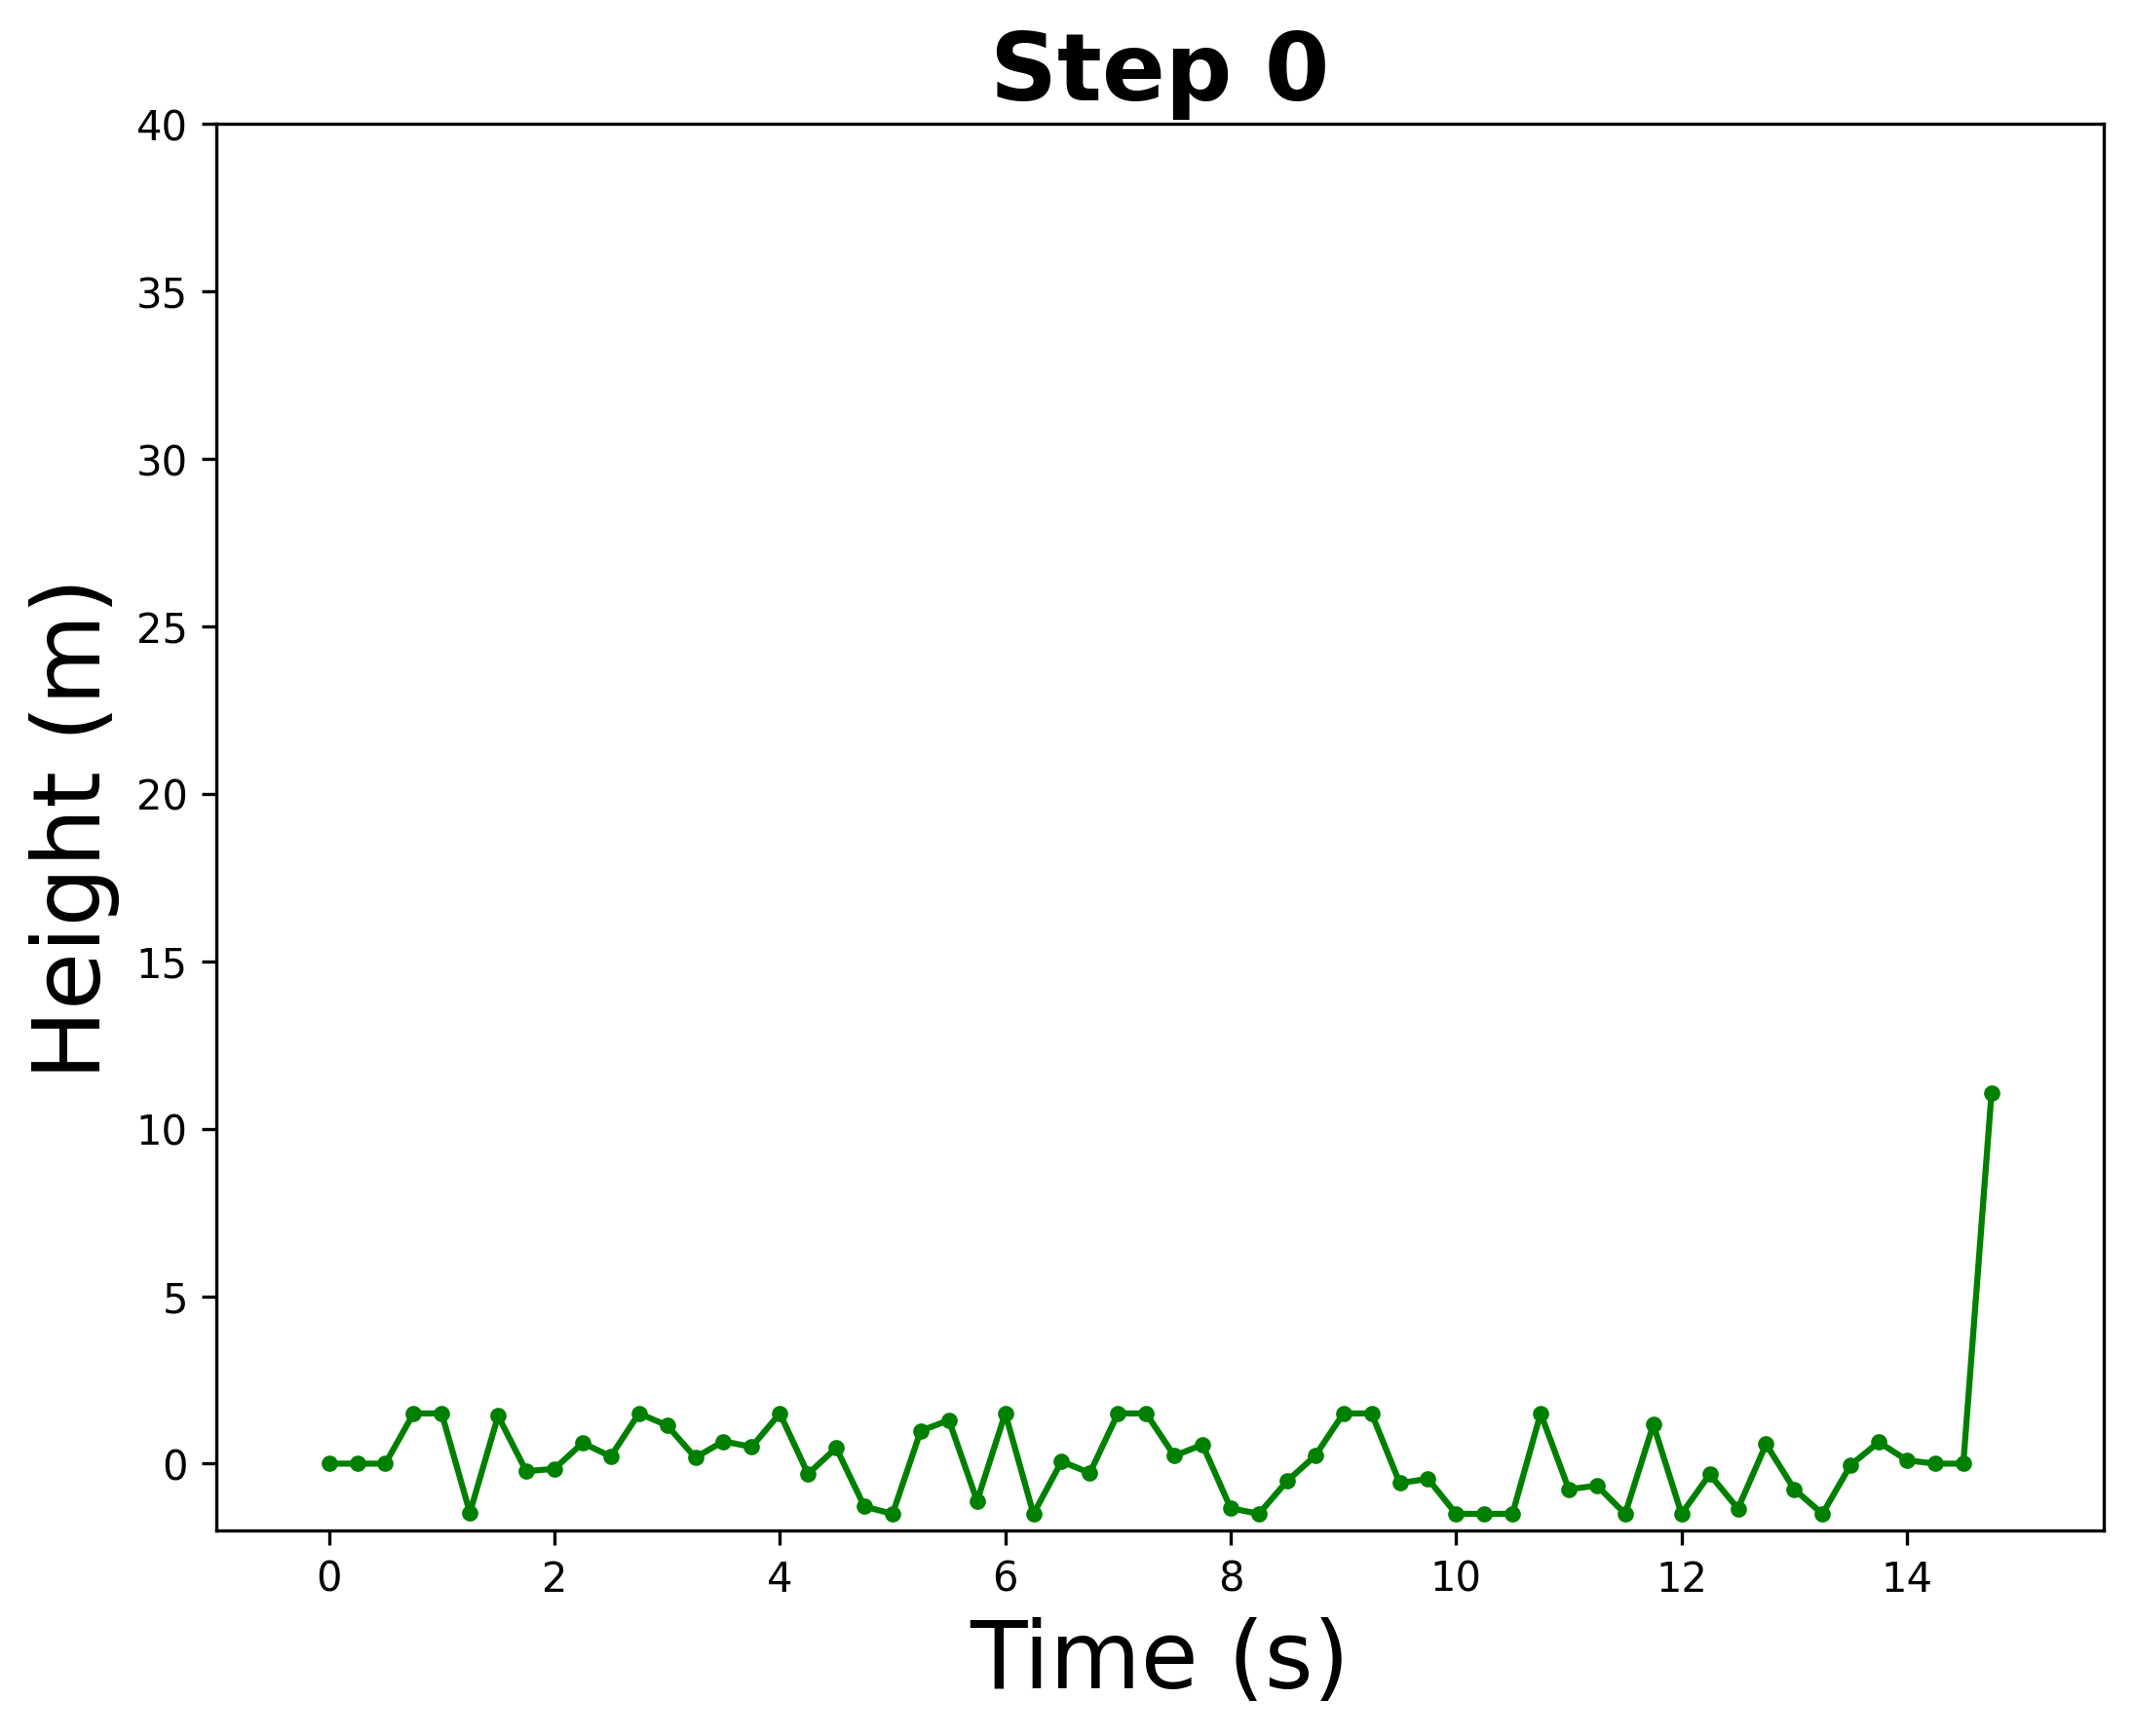

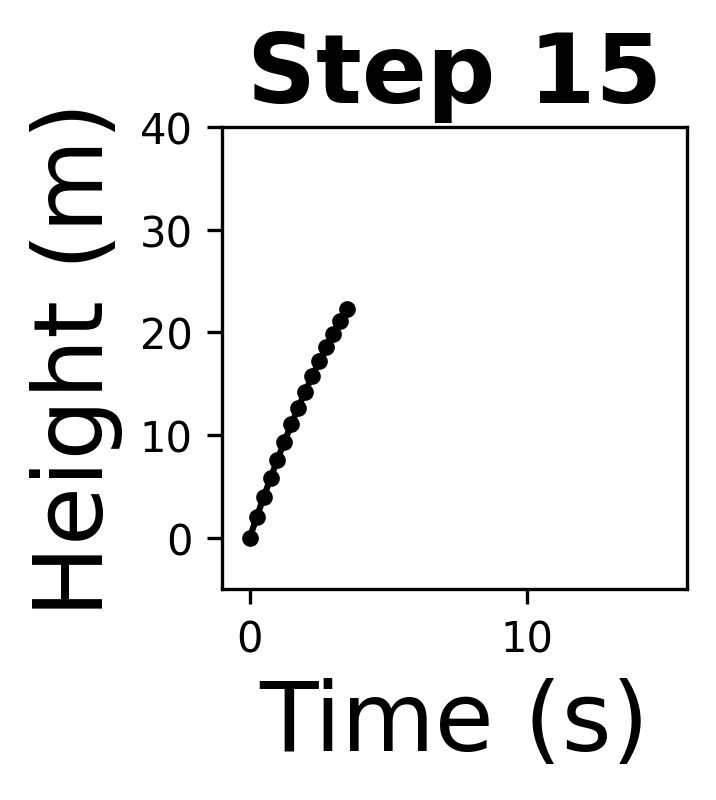

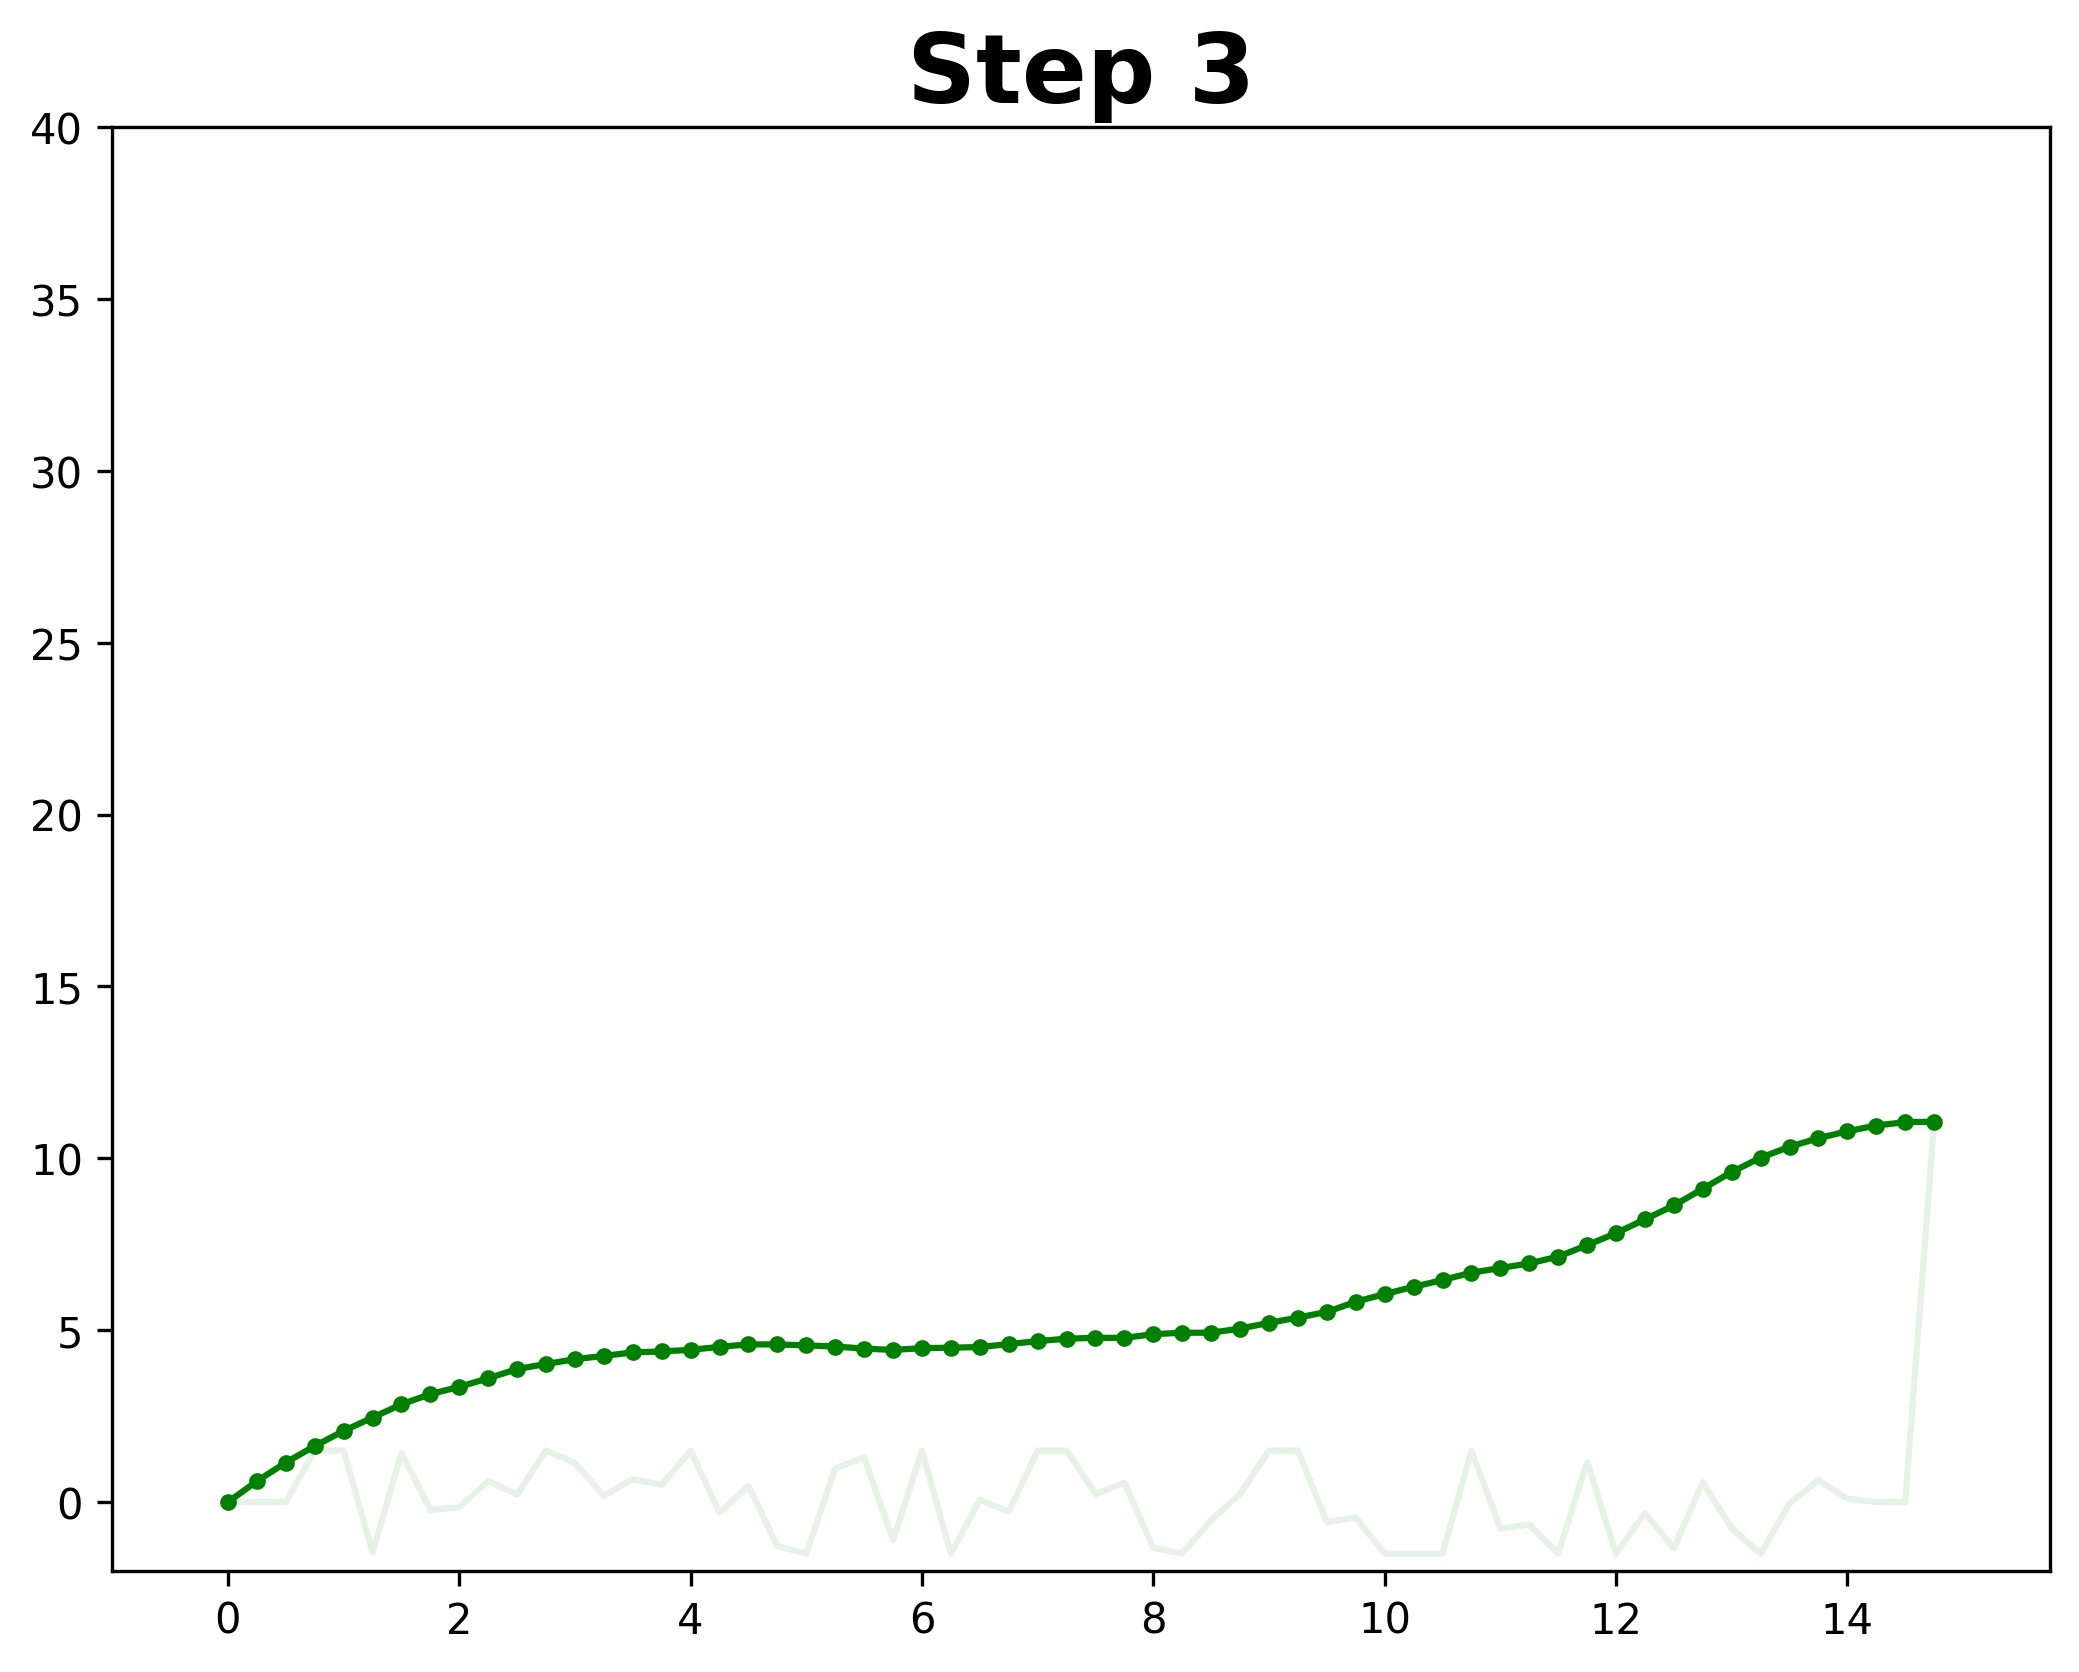

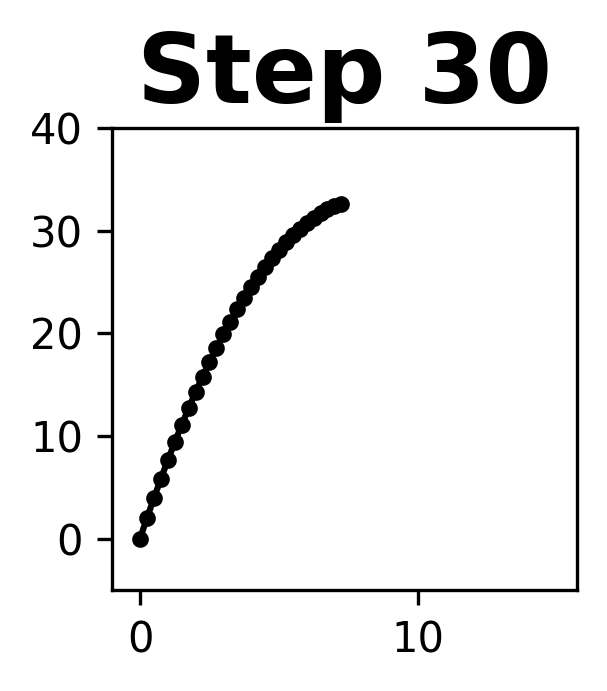

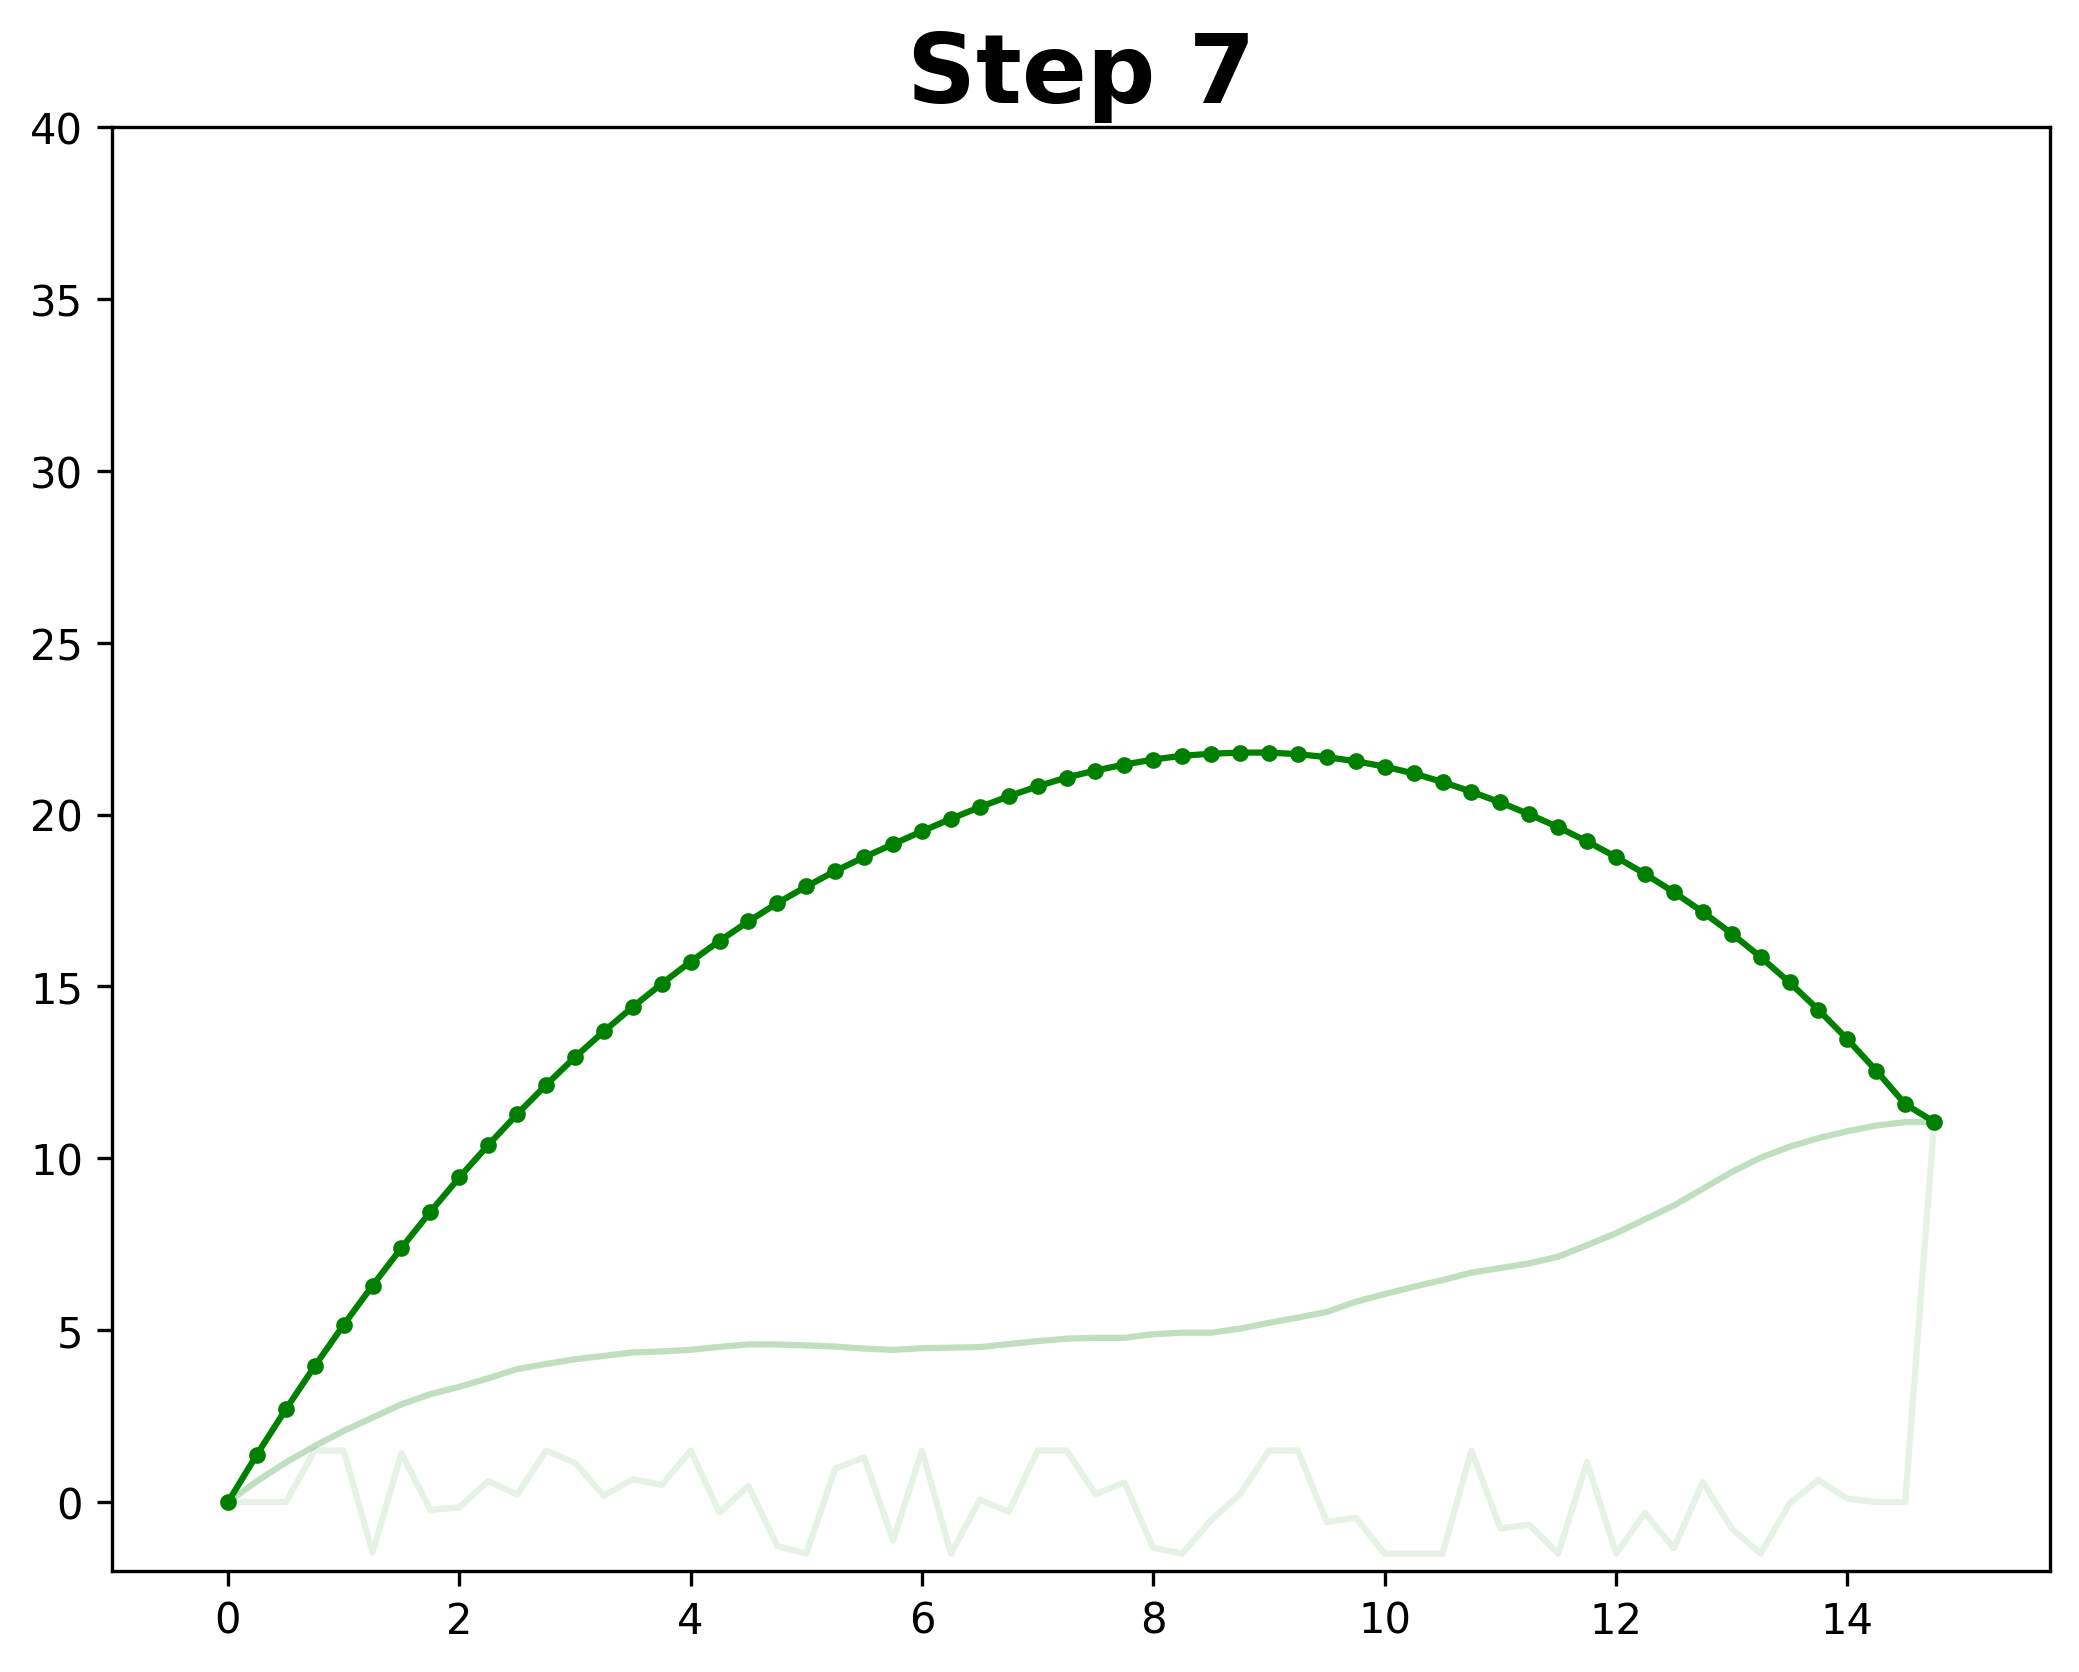

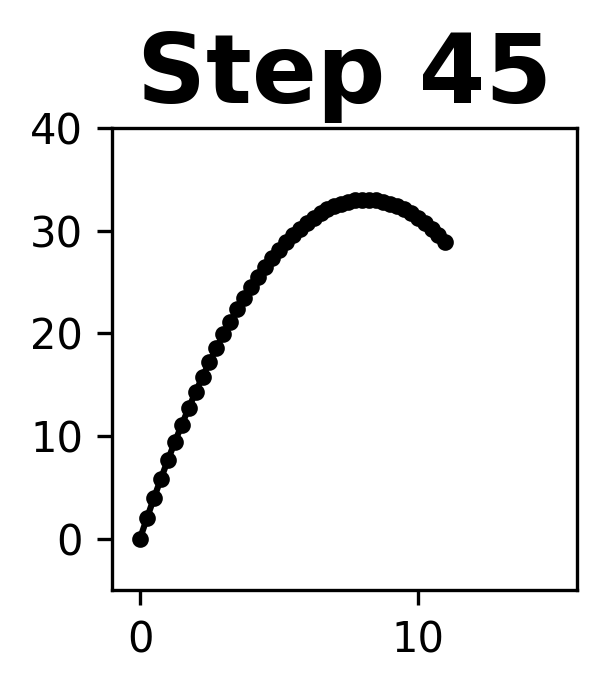

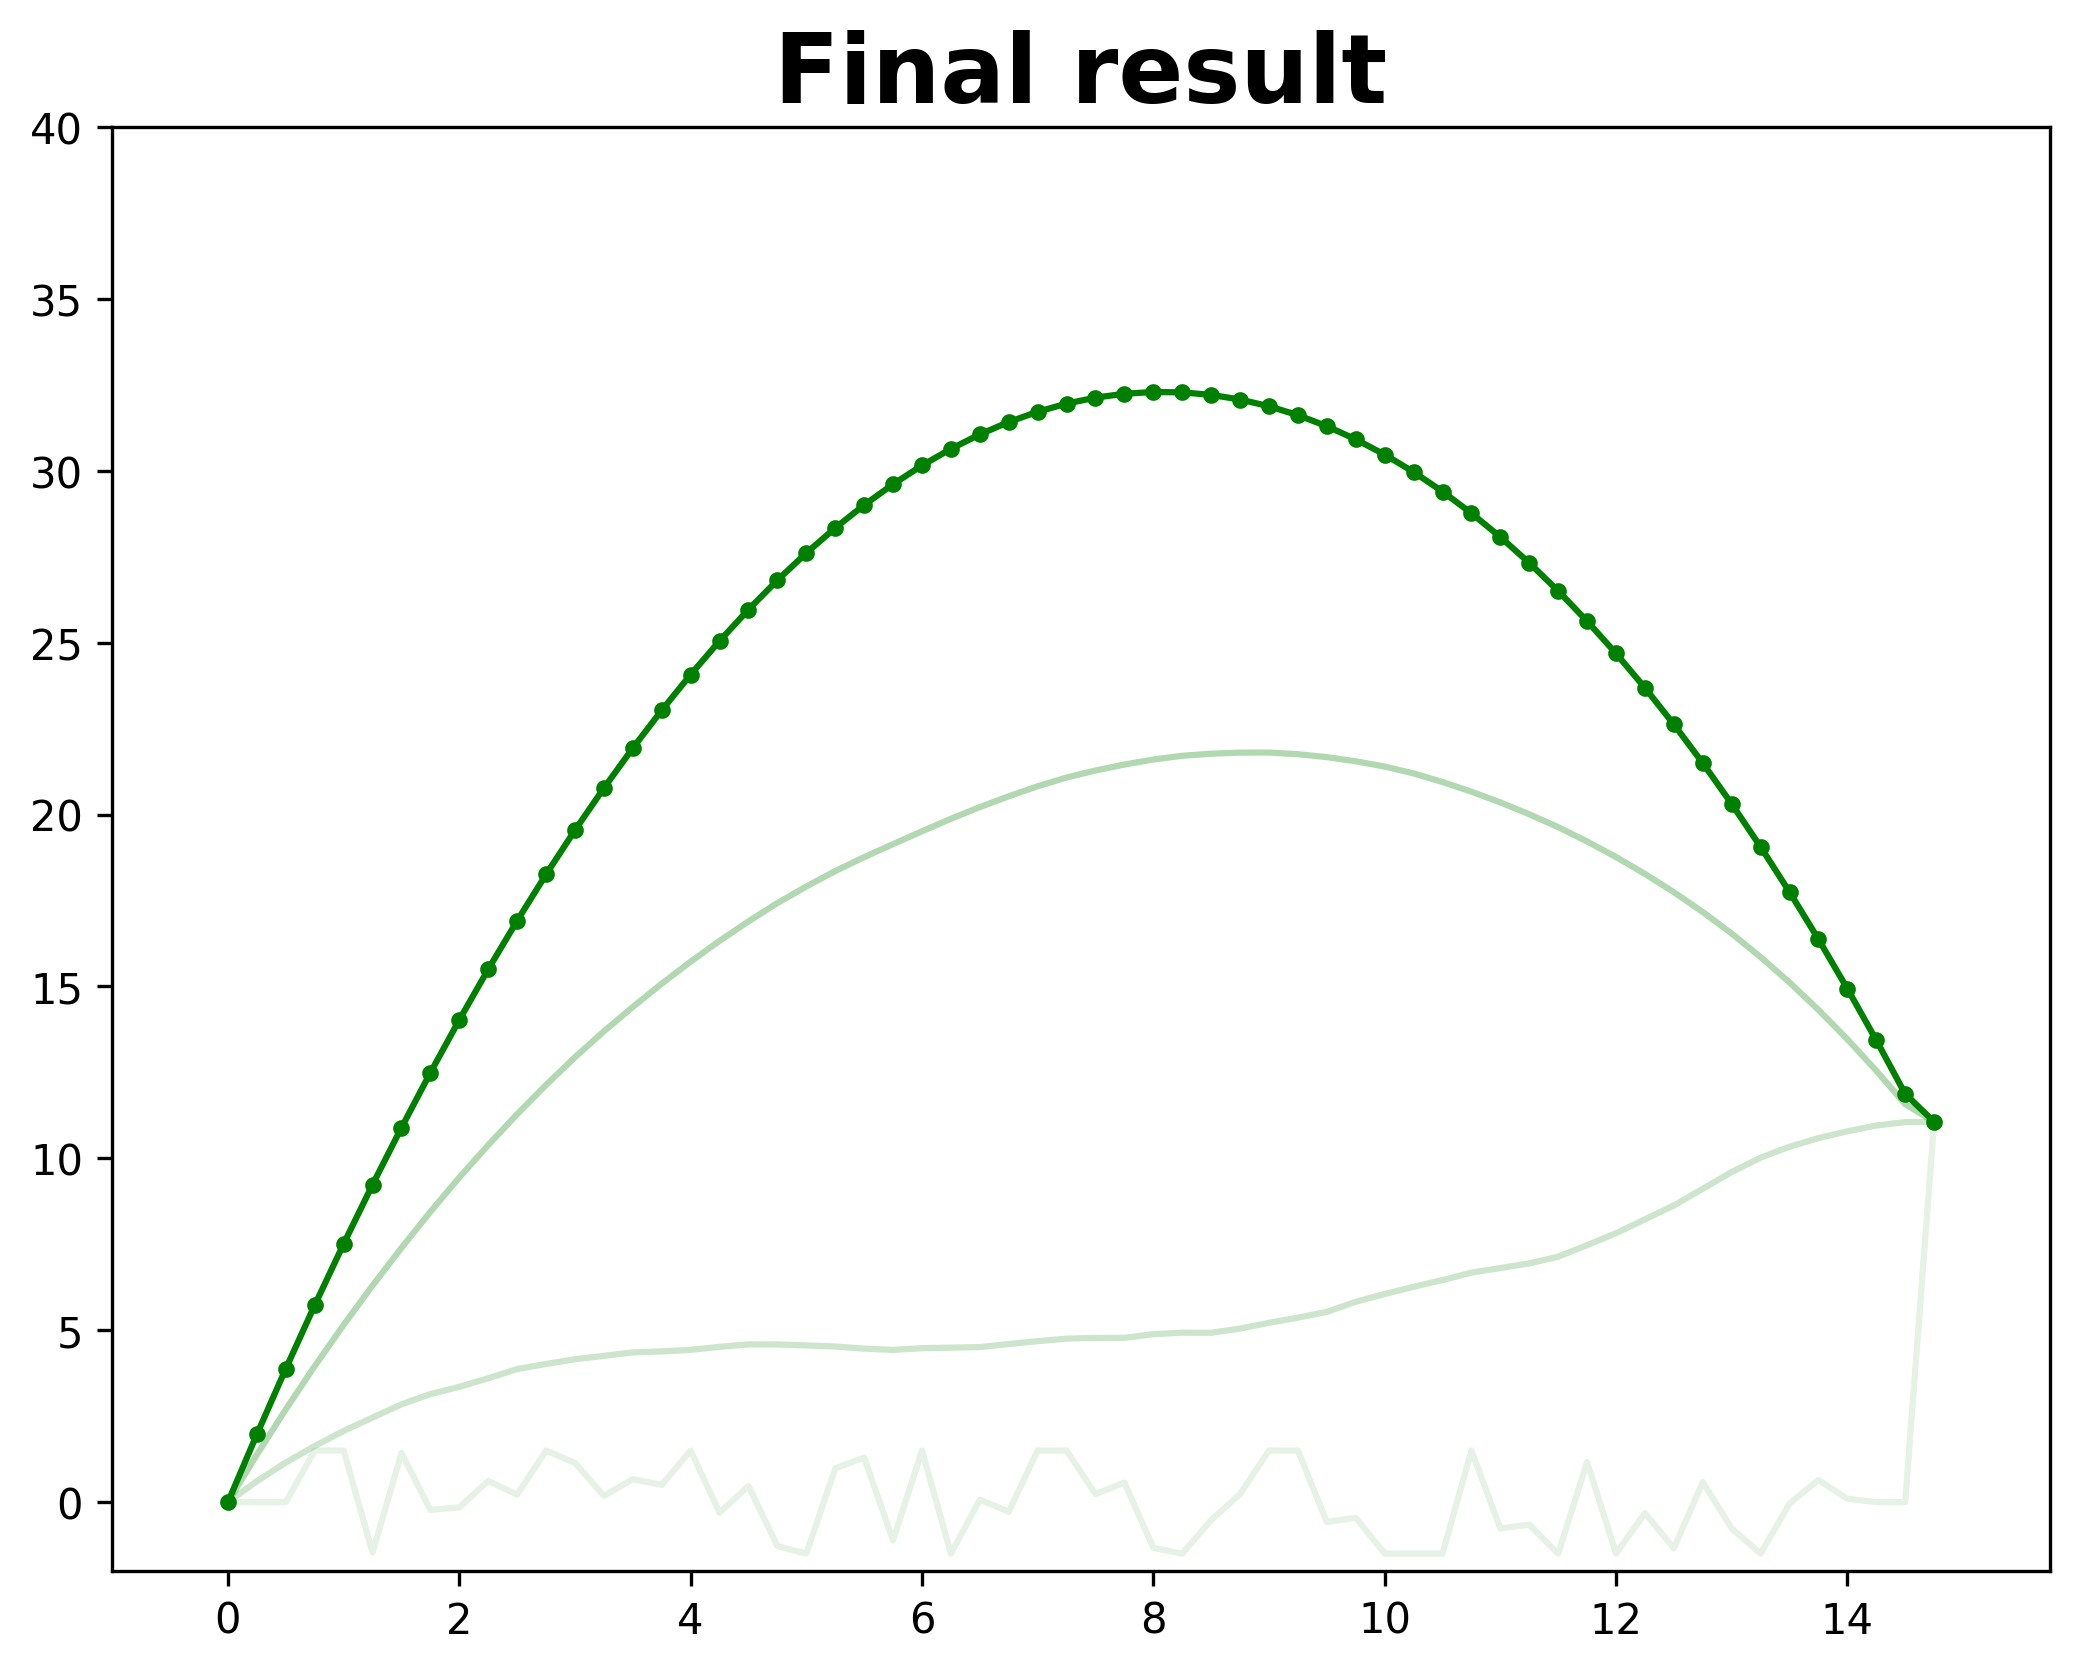

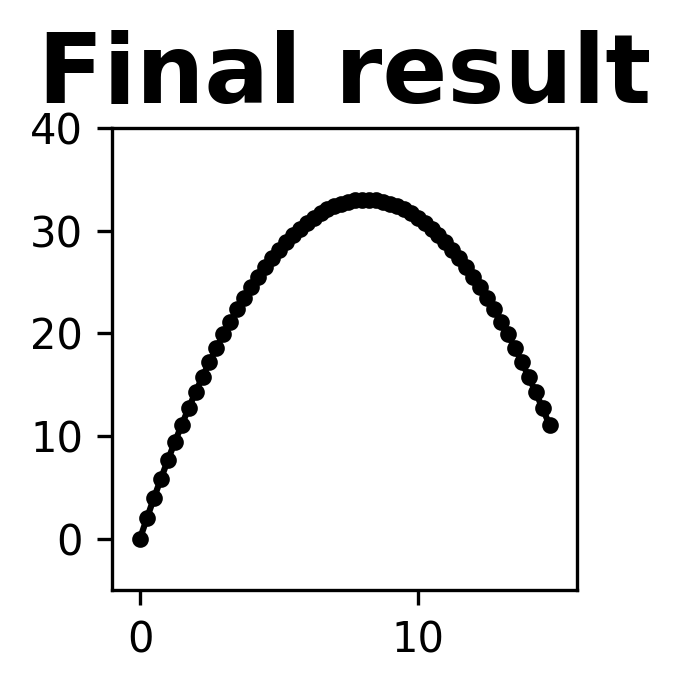

In [21]:
path = 'hero_plot'

def simplot(i, x_sim):
    M_sim = int(len(x_sim)/4)
    fig = plt.figure(figsize=(2, 2), dpi=300)
    ax=fig.add_subplot(111)
    j = i+1
    plt.plot(t_sim[:j*M_sim], x_sim[:j*M_sim], 'k.-')
    plt.xlim(-1, t_sim.max()+1)
    plt.ylim(-5, 40)
    plt.title(f'Step {M_sim * j}', fontsize=23, fontweight='bold')
    if i==0:
        plt.xlabel('Time (s)', fontsize=23)
        plt.ylabel('Height (m)', fontsize=23)
    if i==3:
        plt.title(f'Final result', fontsize=23, fontweight='bold')
    fig.savefig(path + f'\sim_{i}.png')

def minplot(i, min_slice):
    fig = plt.figure(figsize=(8.3333, 6.25), dpi=300)
    plt.plot(t_min, xs_min[int(min_slice[i])], 'g.-')
    plt.xlim(-1, t_min.max()+1)
    plt.ylim(-2, 40)
    plt.title(f'Step {min_slice[i]}', fontsize=23, fontweight='bold')
    
    if i == 0:
        plt.xlabel('Time (s)', fontsize=23)
        plt.ylabel('Height (m)', fontsize=23)
    
    if i==3:
        plt.title(f'Final result', fontsize=23, fontweight='bold')
    
    j = i
    while j>0:
        j = j-1
        slc= int(min_slice[j])
        plt.plot(t_min, xs_min[slc], 'g', alpha=.1 + .3*j/i)
    fig.savefig(path + f'\min_{i}.png')
    

min_slice=[0, 3, 7, -1]
for i in range(4):
    minplot(i, min_slice)
    simplot(i, x_sim)

In [ ]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=300) 
ax = fig.add_subplot(111)
name = 'Free body'
ax.plot(t_sim, x_sim, 'r-', label='ODE solution', linewidth=3)
ax.plot(t_min, xs_min[0], 'y.-', alpha=.3, label='Initial (random) path')
for i, xi in enumerate(xs_min):
    label = 'During optimization' if i==10 else None
    ax.plot(t_min, xi, alpha=.3 + .7 * i/(len(xs_min)-1), color=plt.cm.viridis( 1-i/(len(xs_min)-1) ), label=label)
ax.plot(t_min, xs_min[-1], 'b.-', label='Final (optimized) path')
ax.plot(t_min[[0,-1]], xs_min[0].data[[0,-1]], 'b+', markersize=15, label='Points held constant')

plt.ylim(-5, 40)

fontsz = {'title': 23, 'x_label': 23, 'y_label': 23, 'legend': 10}
ax_labels = {'title':'Free Body Height vs Time',
             'x_label':'Time (s)', 'y_label':'Height (m)'}
plot_helper(ax, ax_labels, fontsz, legend=True)
path ='./dynamic/{}.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

In [ ]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 17, 'x_label': 23, 'y_label': 28, 'legend': 14}
fig = action_plot(info, x_sim, ax_labels, fontsz, L_fn=lagrangian_freebody, legend=True)
plt.ylim(-25, 20)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

## Single pendulum

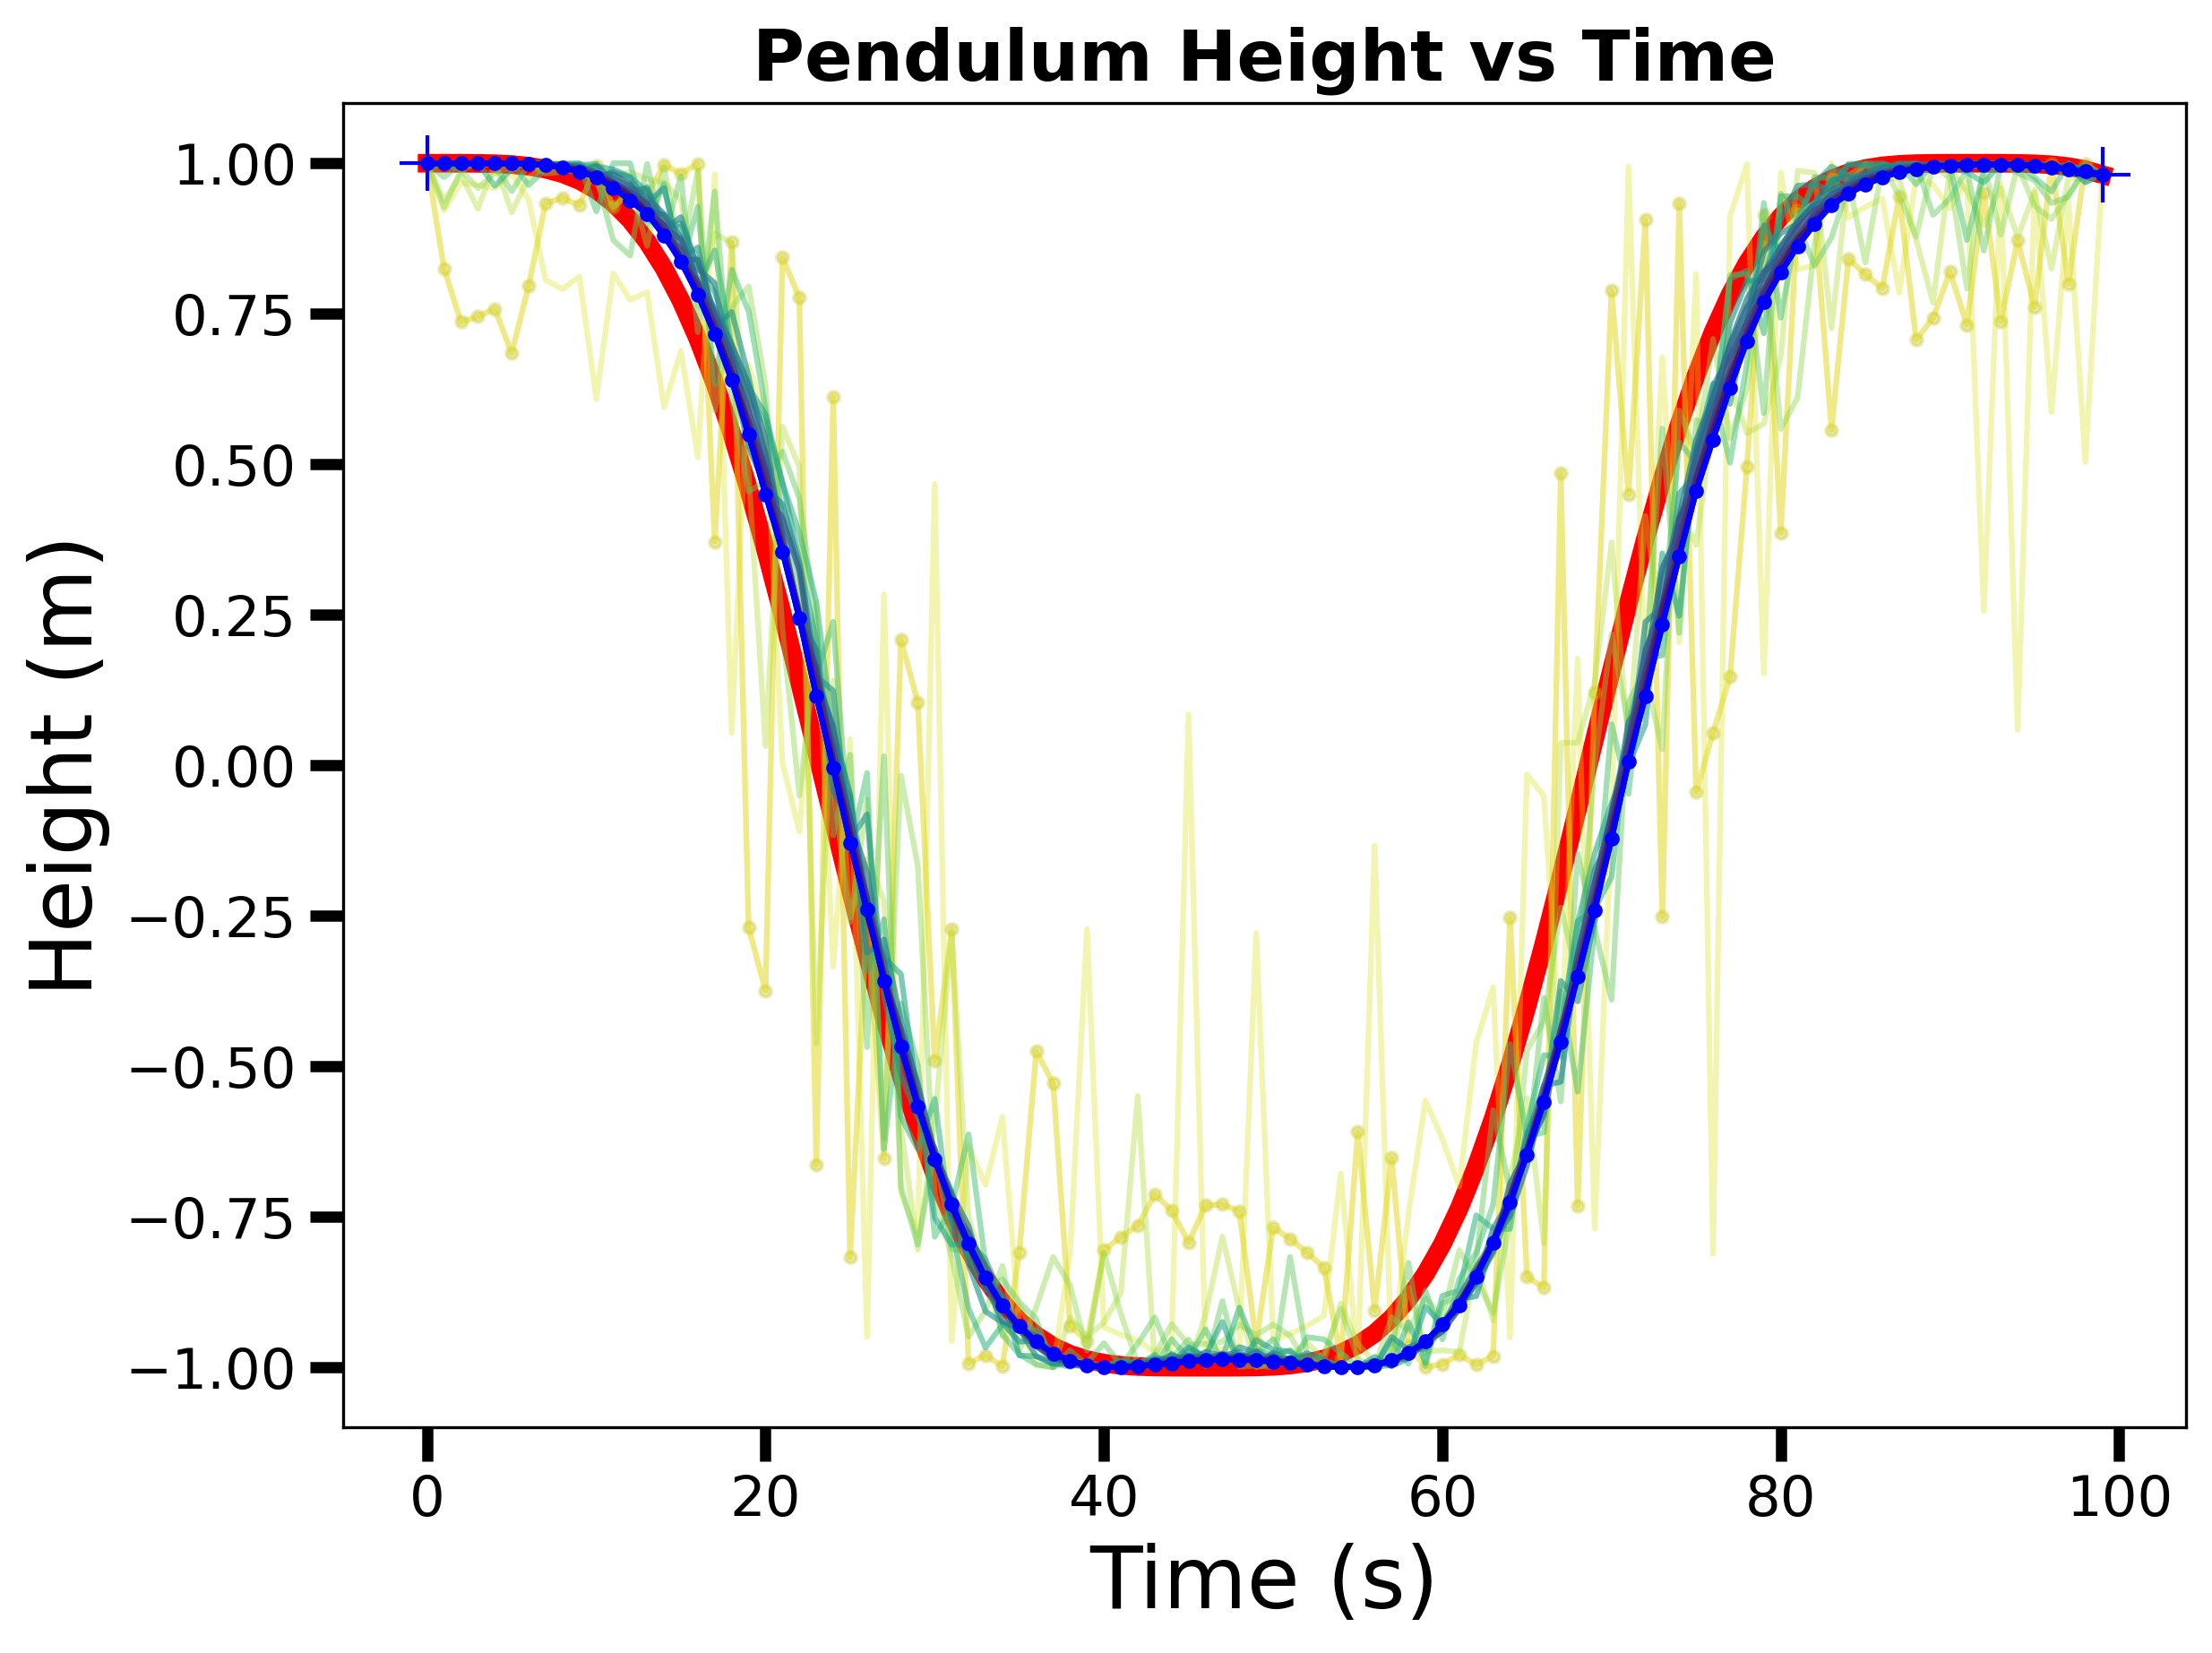

In [6]:
dt = 1 ; N = 1
t_sim, x_sim = simulate_pend(dt=dt)

init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1.5e0, zero_basepath=False, clip_rng=.5) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=100, step_size=1e0, 
                                            L_fn=lagrangian_pend, dt=dt, opt='adam', verbose=False)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=300) 
ax = fig.add_subplot(111)
name = 'Pendulum'
ax.plot(t_sim, np.sin(x_sim), 'r-', label='ODE solution', linewidth=5)
ax.plot(t_min, np.sin(xs_min[0]), 'y.-', alpha=.3, label='Initial (random) path')
for i, xi in enumerate(xs_min):
    label = 'During optimization' if i==10 else None
    ax.plot(t_min, np.sin(xi), alpha=.3 + .7 * i/(len(xs_min)-1), color=plt.cm.viridis( 1-i/(len(xs_min)-1) ), label=label)
ax.plot(t_min, np.sin(xs_min[-1]), 'b.-', label='Final (optimized) path')
ax.plot(t_min[[0,-1]], np.sin(xs_min[0].data[[0,-1]]), 'b+', markersize=15, label='Points held constant')

fontsz = {'title': 19, 'x_label': 23, 'y_label': 23, 'legend': 10}
ax_labels = {'title':'Pendulum Height vs Time',
             'x_label':'Time (s)', 'y_label':'Height (m)'}
plot_helper(ax, ax_labels, fontsz)
path ='./dynamic/{}.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

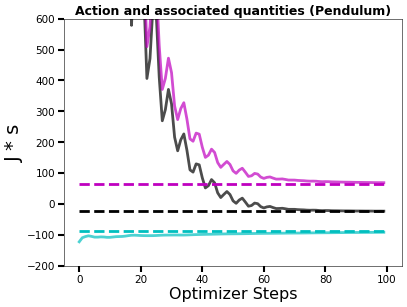

In [7]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 28, 'legend': 10}
fig = action_plot(info, x_sim, ax_labels, fontsz, L_fn=lagrangian_pend)
plt.ylim(-200, 600)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

## Double pendulum

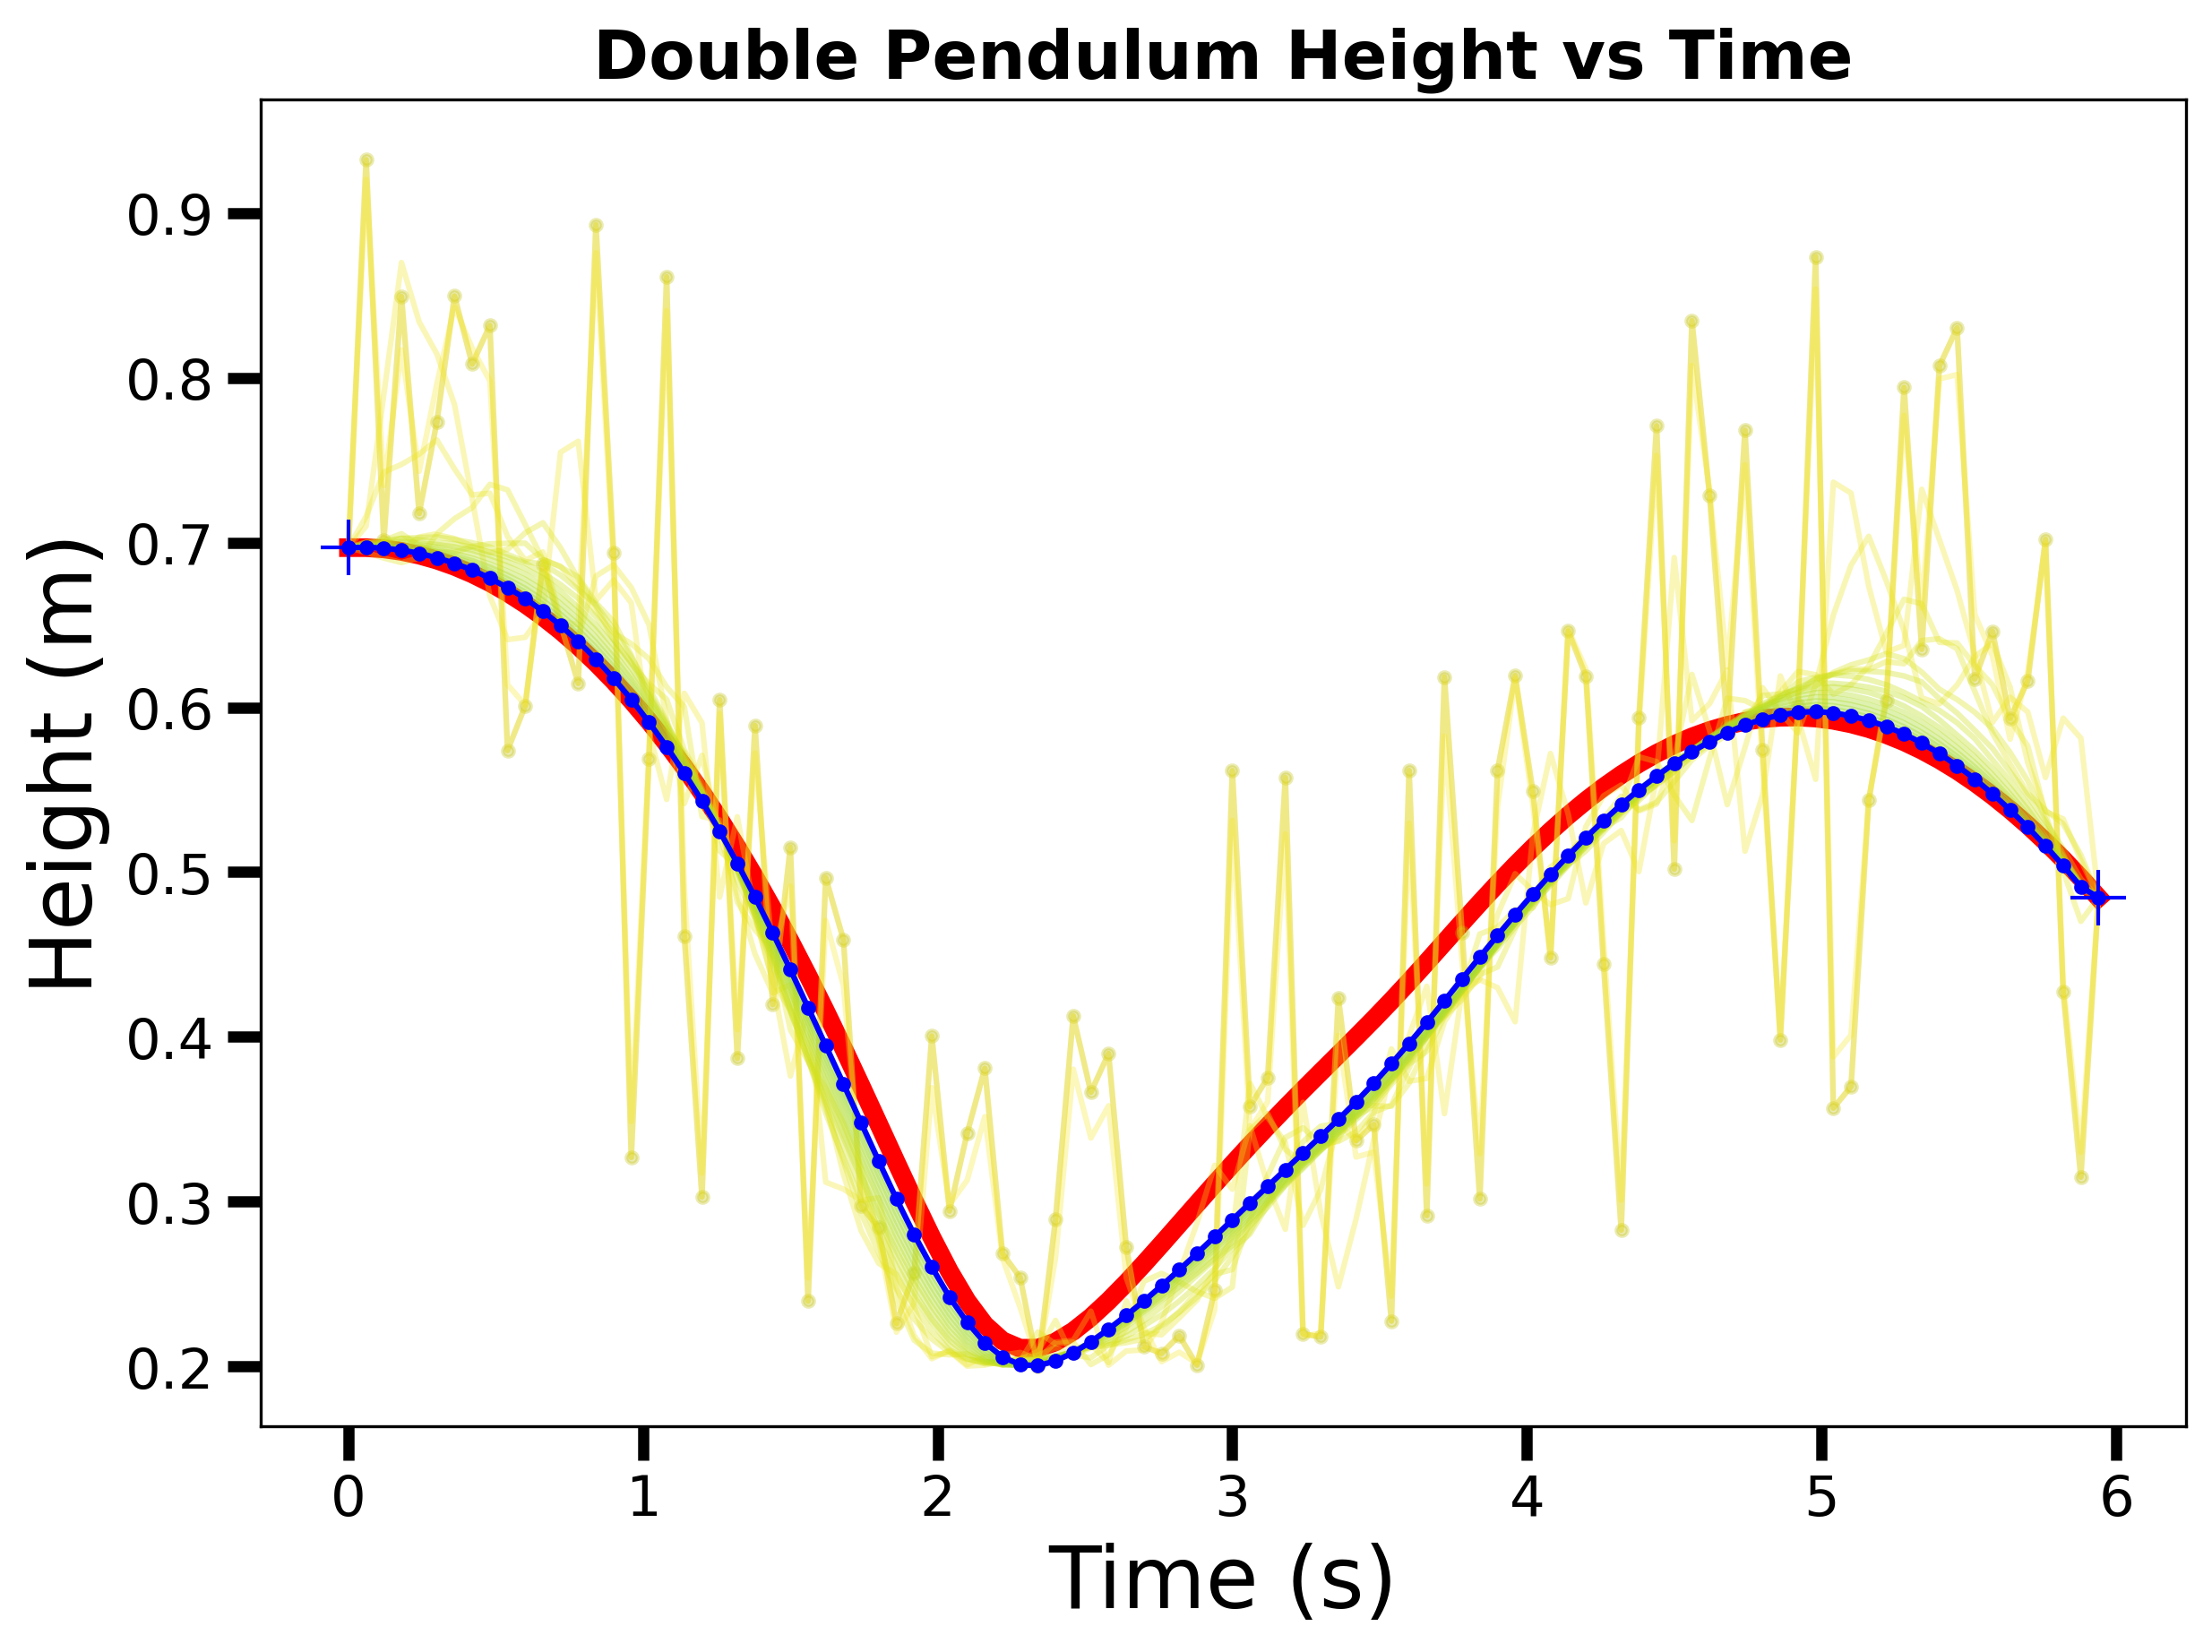

In [10]:
dt = 0.06 ; N = 2
t_sim, x_sim = simulate_dblpend(dt=dt)

init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1e0, zero_basepath=False)
t_min, path, xs_min, info = minimize_action(init_path, steps=200, step_size=1e-1, 
                                            L_fn=lagrangian_dblpend, dt=dt, opt='adam', verbose=False)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=300)
ax = fig.add_subplot(111)
name = 'Double pendulum'
nm, xy = (1, 1)
radsim = radial2cartesian(x_sim)[:, nm, xy]
size = len(radsim)
ax.plot(t_sim, radsim, 'r-', label='ODE solution', linewidth=5)
ax.plot(t_min, radial2cartesian(xs_min[0])[:, nm, xy], 'y.-', alpha=.3, label='Initial (random) path')
for i, xi in enumerate(xs_min):
    label = 'During optimization' if i==10 else None
    ax.plot(t_min, radial2cartesian(xs_min[i])[:, nm, xy],
             alpha=.3 + .7 * i/(size - 1), 
             color=plt.cm.viridis( 1-i/(size - 1)), label=label)
ax.plot(t_min, radial2cartesian(xs_min[-1])[:, nm, xy], 'b.-', label='Final (optimized) path')
ax.plot(t_min[[0,-1]], radial2cartesian(xs_min[0])[[0,-1], nm, xy],
         'b+', markersize=15, label='Points held constant')

ax_labels = {'title':'Double Pendulum Height vs Time',
             'x_label':'Time (s)', 'y_label':'Height (m)'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 23, 'legend': 10}
plot_helper(ax, ax_labels, fontsz)

path ='./dynamic/{}.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)


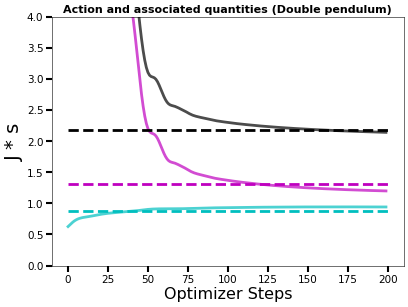

In [12]:
name = 'Double pendulum'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
fig = action_plot(info, x_sim, ax_labels, fontsz, L_fn=lagrangian_dblpend)
plt.ylim(0, 4)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

## Three body problem

In [66]:
dt = 0.5 ; N = 3

t_sim, x_sim = simulate_3body(dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=2e-1) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=125, step_size=1e-1,
                                       L_fn=lagrangian_3body, dt=dt, opt='adam')

step=0000, S=1.649e-01 J*s, dt=0.1s
step=0008, S=1.857e-02 J*s, dt=0.4s
step=0016, S=8.372e-03 J*s, dt=0.5s
step=0024, S=4.391e-03 J*s, dt=0.4s
step=0032, S=2.176e-03 J*s, dt=0.4s
step=0040, S=1.382e-03 J*s, dt=0.5s
step=0048, S=9.181e-04 J*s, dt=0.5s
step=0056, S=6.621e-04 J*s, dt=0.4s
step=0064, S=5.685e-04 J*s, dt=0.4s
step=0072, S=5.303e-04 J*s, dt=0.5s
step=0080, S=5.049e-04 J*s, dt=0.5s
step=0088, S=4.942e-04 J*s, dt=0.5s
step=0096, S=4.878e-04 J*s, dt=0.5s
step=0104, S=4.836e-04 J*s, dt=0.4s
step=0112, S=4.803e-04 J*s, dt=0.5s
step=0120, S=4.775e-04 J*s, dt=0.5s


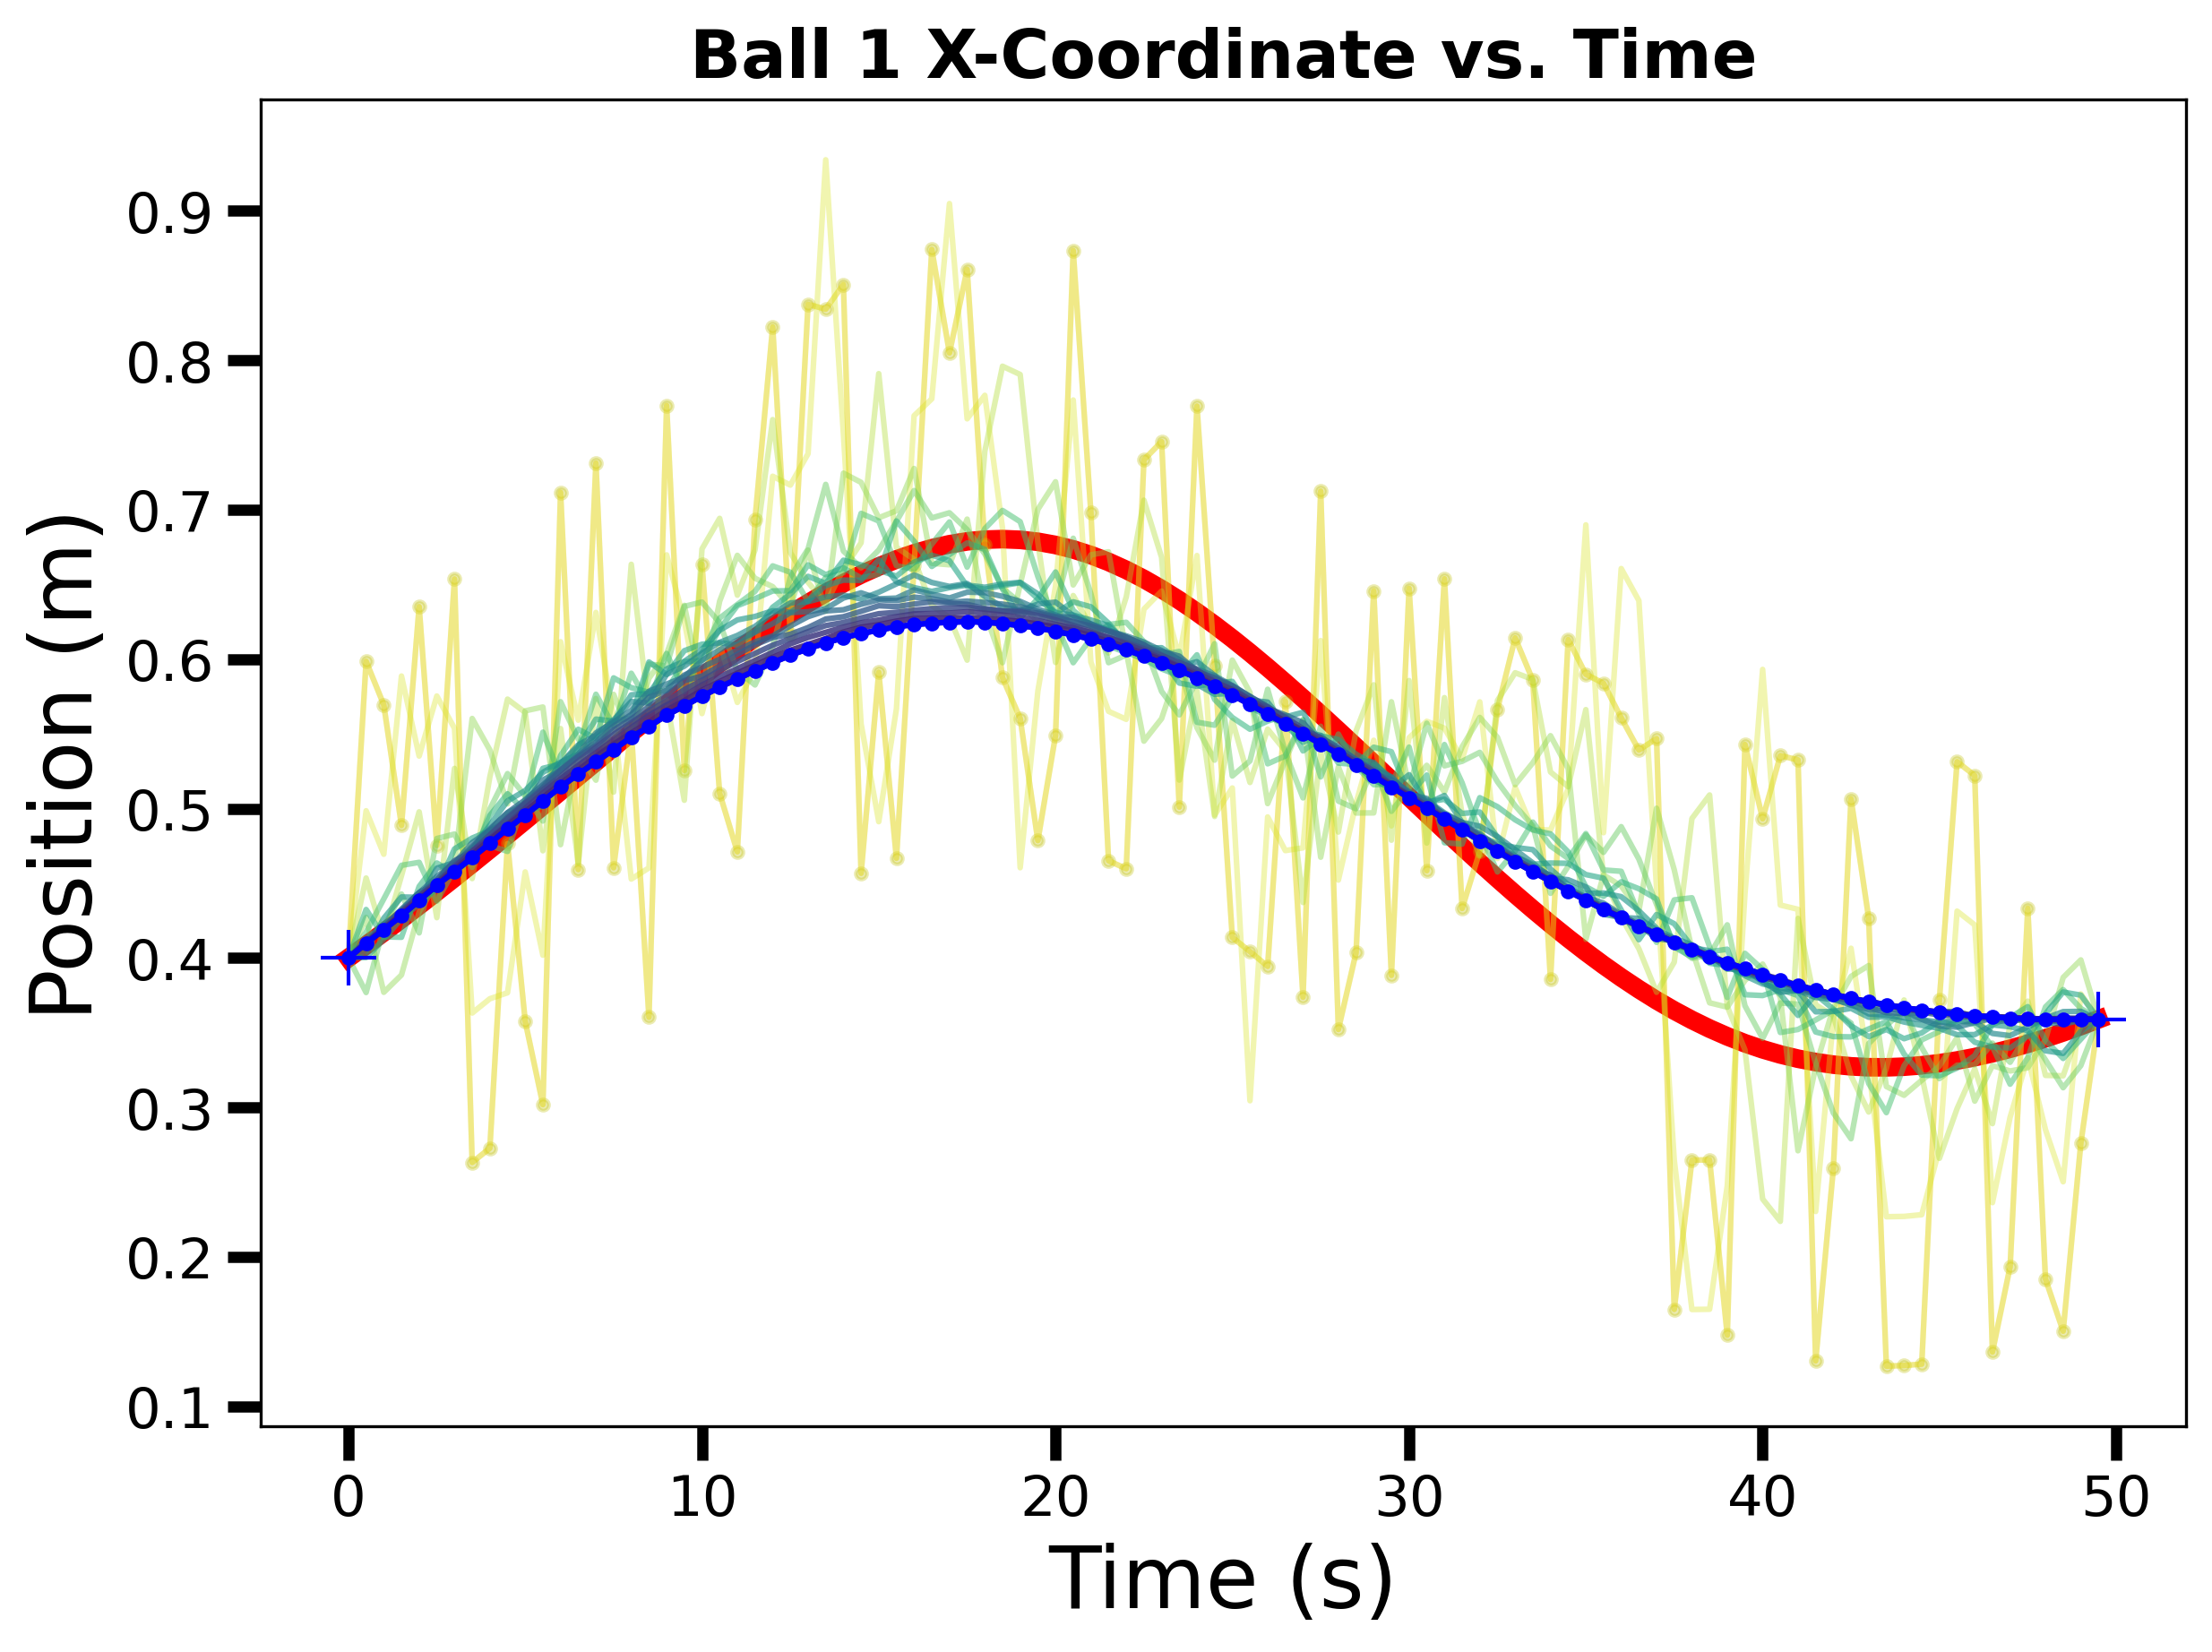

In [67]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=300)
ax = fig.add_subplot(111)

k = 0
name = 'Three body ball 1 xcoord'
ax.plot(t_min, x_sim[:, 0, k], 'r-', label='ODE solution', linewidth=5)
ax.plot(t_min, xs_min[0].reshape(x_sim.shape)[:, 0, k], 'y.-', alpha=.3, label='Initial (random) path')
for i, xi in enumerate(xs_min):
    label = 'During optimization' if i==10 else None
    ax.plot(t_min, xs_min[i].detach().numpy().reshape(x_sim.shape)[:, 0, k], alpha=.3 + .7 * i/(17), color=plt.cm.viridis( 1-i/(17) ), label=label)
ax.plot(t_min, xs_min[-1].detach().numpy().reshape(x_sim.shape)[:, 0, k], 'b.-', label='Final (optimized) path')
ax.plot(t_min[[0,-1]], xs_min[0].detach().reshape(x_sim.shape)[:, 0, k][[0,-1]], 'b+', markersize=15, label='Points held constant')


ax_labels = {'title':'Ball {} X-Coordinate vs. Time'.format(1 + k//2),
             'x_label':'Time (s)', 'y_label':'Position (m)'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 23, 'legend': 10}

plot_helper(ax, ax_labels, fontsz)
path ='./dynamic/{}.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

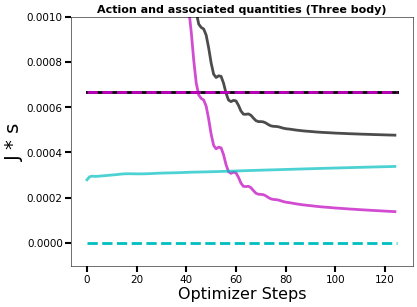

In [68]:
name = 'Three body'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
fig = action_plot(info, x_sim, ax_labels, fontsz, L_fn=lagrangian_3body)
plt.ylim(-.0001, .001)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

## Gas simulation

In [69]:
dt = 0.5 ; N = 50
t_sim, x_sim = simulate_gas(dt=dt, N=N)
init_path = PerturbedPath(x_sim, N=N, sigma=1e-3)
t_min, path, xs_min, info = minimize_action(init_path, steps=100, step_size=1e-2,
                                       L_fn=lagrangian_gas, dt=dt, opt='adam')

step=0000, S=-5.671e-04 J*s, dt=0.1s
step=0006, S=-4.278e-04 J*s, dt=0.7s
step=0012, S=-5.352e-04 J*s, dt=0.7s
step=0018, S=-5.640e-04 J*s, dt=0.6s
step=0024, S=-5.783e-04 J*s, dt=0.7s
step=0030, S=-5.873e-04 J*s, dt=0.7s
step=0036, S=-5.938e-04 J*s, dt=0.7s
step=0042, S=-6.019e-04 J*s, dt=0.6s
step=0048, S=-6.121e-04 J*s, dt=0.6s
step=0054, S=-6.225e-04 J*s, dt=0.6s
step=0060, S=-6.293e-04 J*s, dt=0.7s
step=0066, S=-6.345e-04 J*s, dt=0.6s
step=0072, S=-6.399e-04 J*s, dt=0.7s
step=0078, S=-6.433e-04 J*s, dt=0.6s
step=0084, S=-6.472e-04 J*s, dt=0.6s
step=0090, S=-6.506e-04 J*s, dt=0.7s
step=0096, S=-6.503e-04 J*s, dt=0.6s


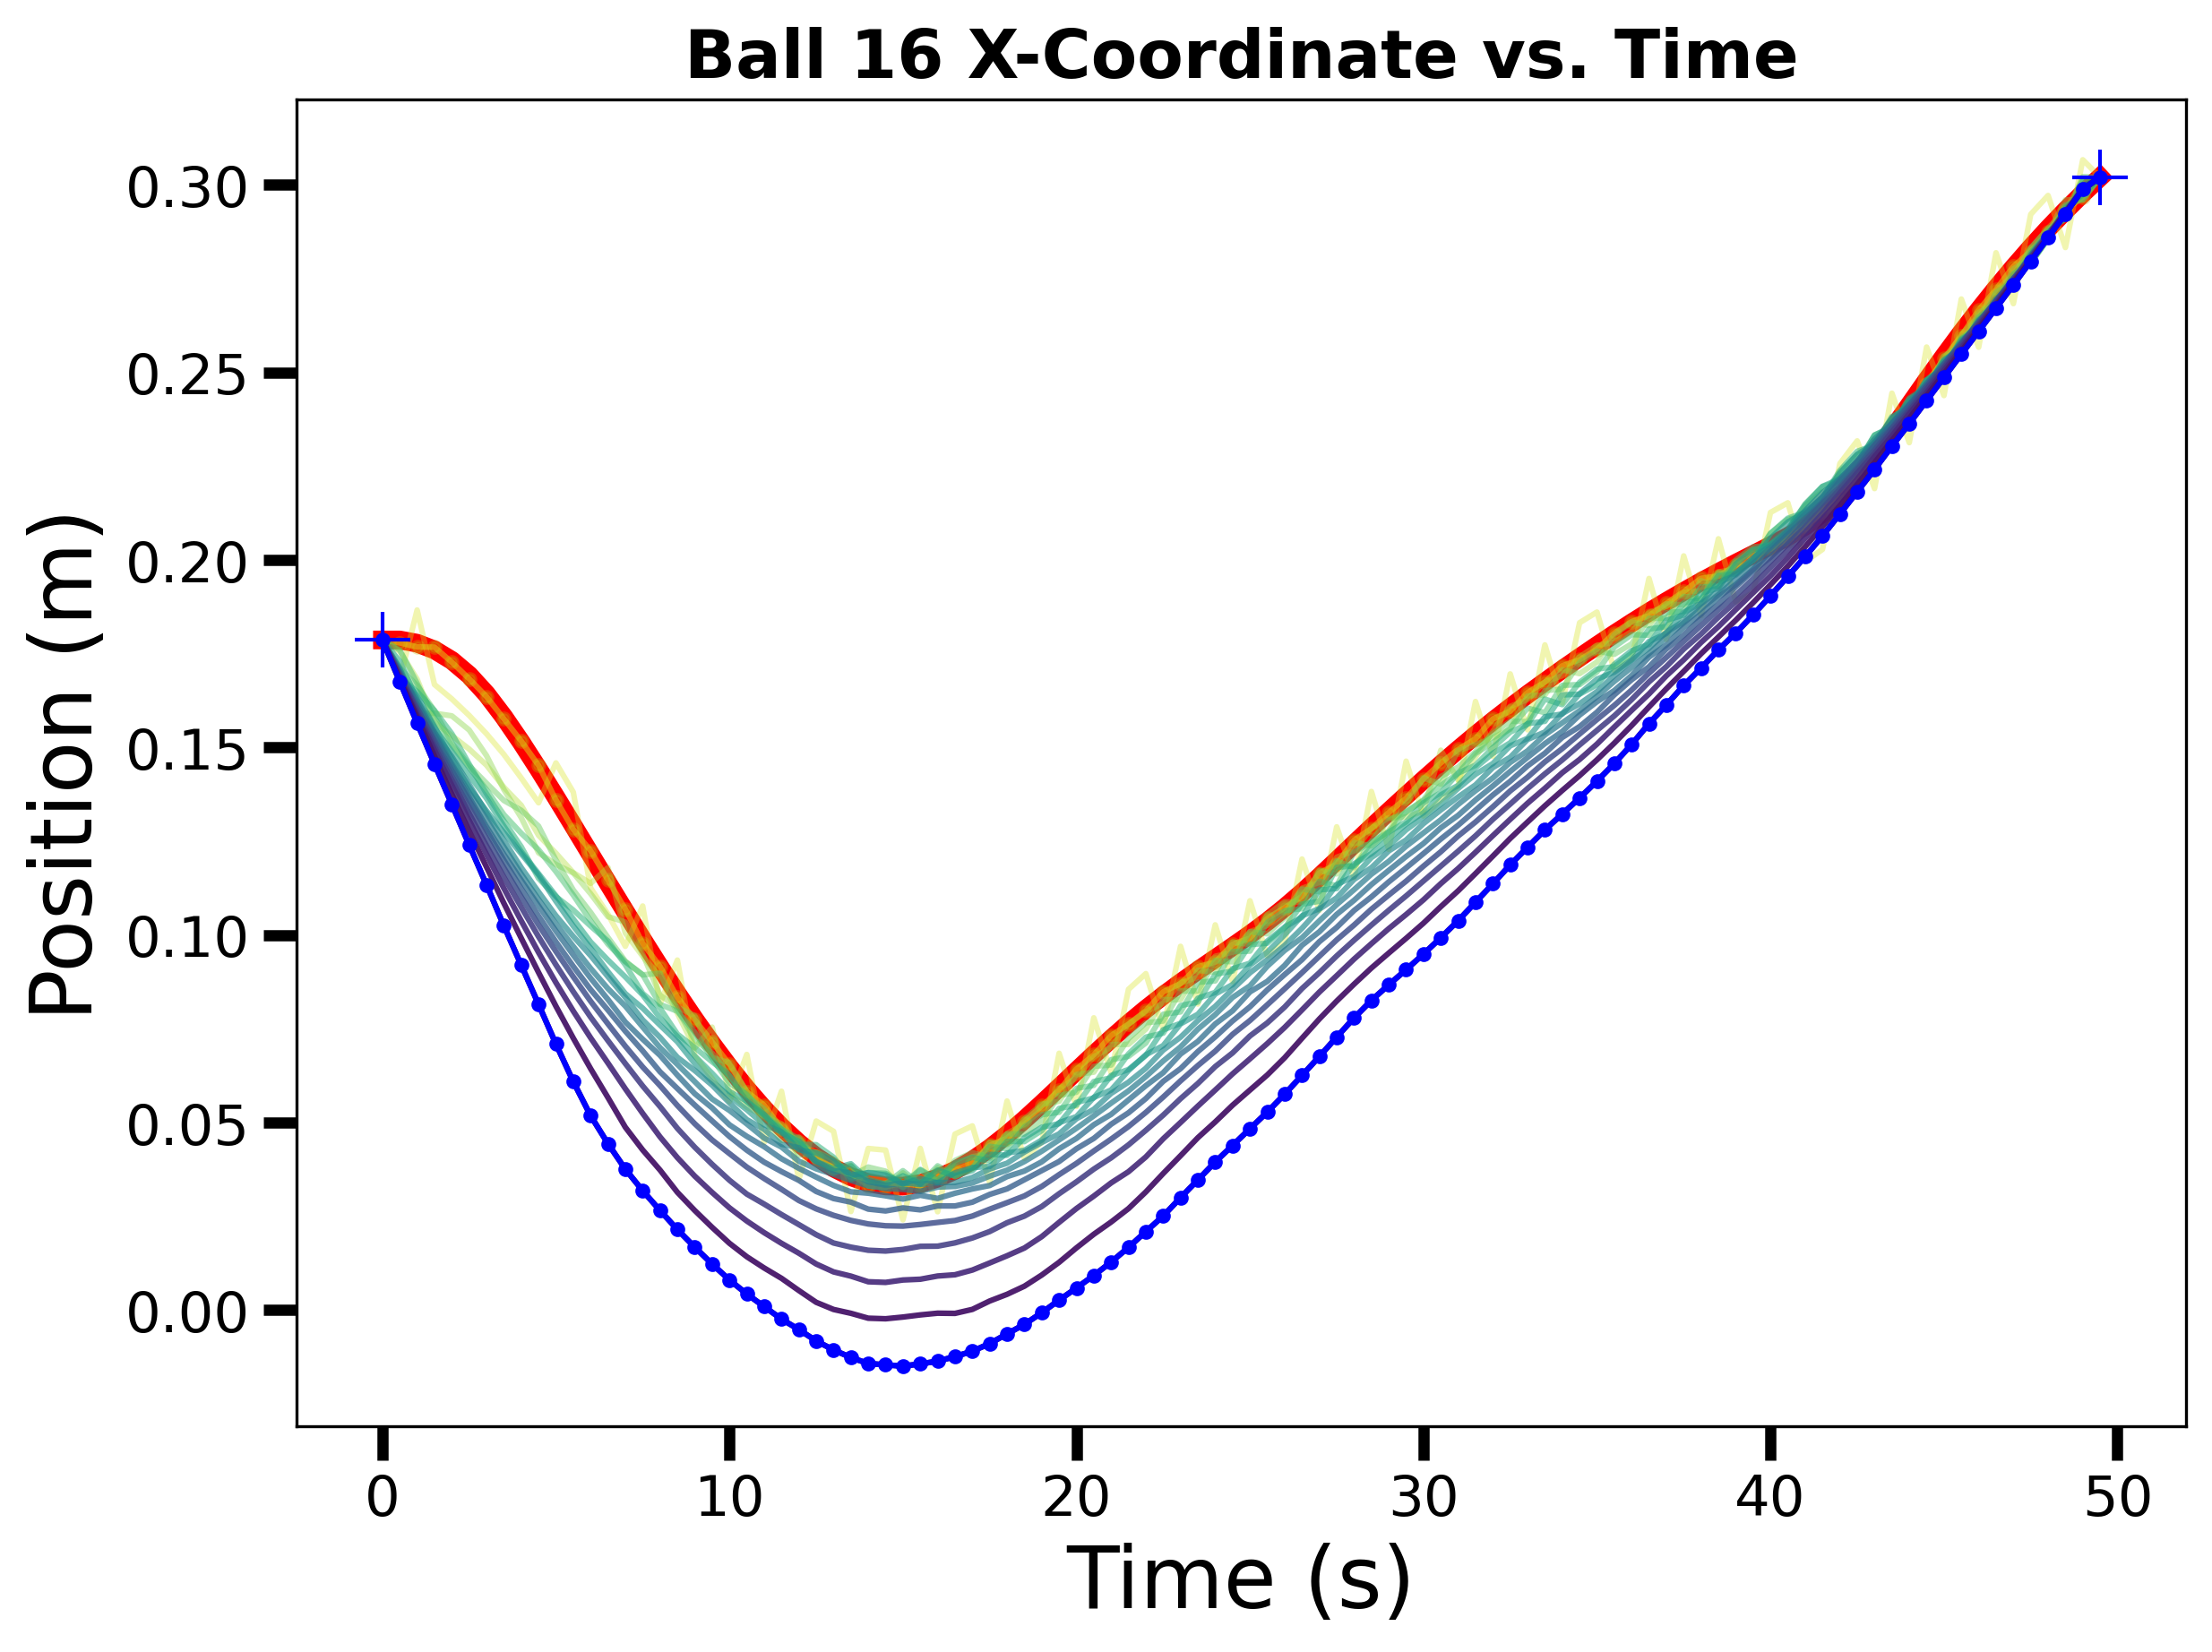

In [70]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=300)
ax = fig.add_subplot(111)

N = x_sim.shape[-2]

k = 30
name = 'Gas particle 16 xcoord'
ax.plot(t_min, x_sim.reshape(-1,N*2)[...,k], 'r-', label='ODE solution', linewidth=5)
ax.plot(t_min, xs_min[0].reshape(-1,N*2)[...,k], 'y.-', alpha=.3, label='Initial (random) path')
for i, xi in enumerate(xs_min):
    label = 'During optimization' if i==10 else None
    ax.plot(t_min, xs_min[i].detach().numpy().reshape(-1,N*2)[...,k], alpha=.3 + .7 * i/(17), color=plt.cm.viridis( 1-i/(17) ), label=label)
ax.plot(t_min, xs_min[-1].detach().numpy().reshape(-1,N*2)[...,k], 'b.-', label='Final (optimized) path')
ax.plot(t_min[[0,-1]], xs_min[0].detach().numpy().reshape(-1,N*2)[...,k][[0,-1]], 'b+', markersize=15, label='Points held constant')


ax_labels = {'title':'Ball {} X-Coordinate vs. Time'.format(1 + k//2),
             'x_label':'Time (s)', 'y_label':'Position (m)'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 23, 'legend': 10}

plot_helper(ax, ax_labels, fontsz)
path ='./dynamic/{}.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

./static/gas_action.pdf


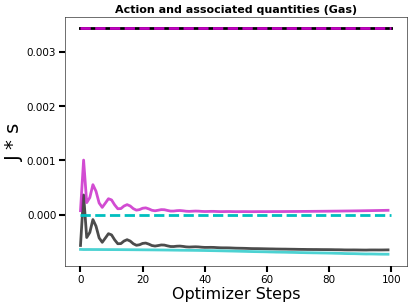

In [71]:
name = 'Gas'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
fig = action_plot(info, x_sim, ax_labels, fontsz, L_fn=lagrangian_3body)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

## Ephemeris dataset and simulation

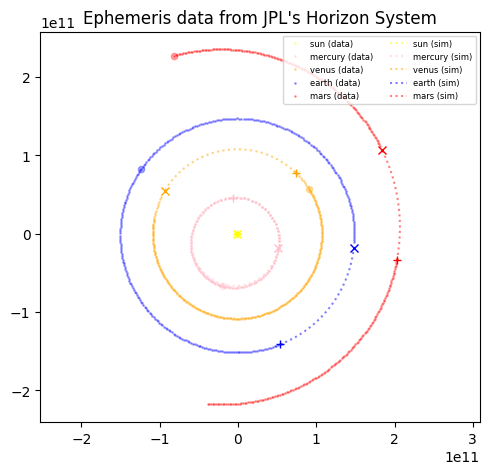

In [72]:
planets = ['sun', 'mercury', 'venus', 'earth', 'mars']
data_dir = './data/'
df = process_raw_ephemeris(planets, data_dir, last_n_days=365) #365

t_sim, x_sim = simulate_planets(df, planets)
plot_planets(df, planets)

colors = get_planet_colors()
for i, (planet, coords) in enumerate(zip(planets, x_sim.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (sim)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=2) ; plt.show()

In [74]:
dt = 24*60*60 ; N = len(planets)
df = process_raw_ephemeris(planets, data_dir, last_n_days=365)
t_sim, x_sim = simulate_planets(df, planets, dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=2e10, is_ephemeris=True)

L_planets = partial(lagrangian_planets, masses=get_masses(planets))

t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e9,
                                       L_fn=L_planets, dt=dt, opt='adam')

Loading ./data/ephemeris_ablate.csv...
step=0000, S=1.259e+35 J*s, dt=0.1s
step=0033, S=1.955e+36 J*s, dt=1.2s
step=0066, S=4.602e+34 J*s, dt=0.9s
step=0099, S=6.424e+33 J*s, dt=1.0s
step=0132, S=4.069e+33 J*s, dt=1.1s
step=0165, S=3.906e+33 J*s, dt=1.1s
step=0198, S=3.843e+33 J*s, dt=1.0s
step=0231, S=3.803e+33 J*s, dt=1.0s
step=0264, S=3.780e+33 J*s, dt=1.0s
step=0297, S=3.766e+33 J*s, dt=1.0s
step=0330, S=3.758e+33 J*s, dt=0.9s
step=0363, S=3.754e+33 J*s, dt=1.0s
step=0396, S=3.752e+33 J*s, dt=1.0s
step=0429, S=3.751e+33 J*s, dt=1.1s
step=0462, S=3.751e+33 J*s, dt=1.1s
step=0495, S=3.750e+33 J*s, dt=1.0s


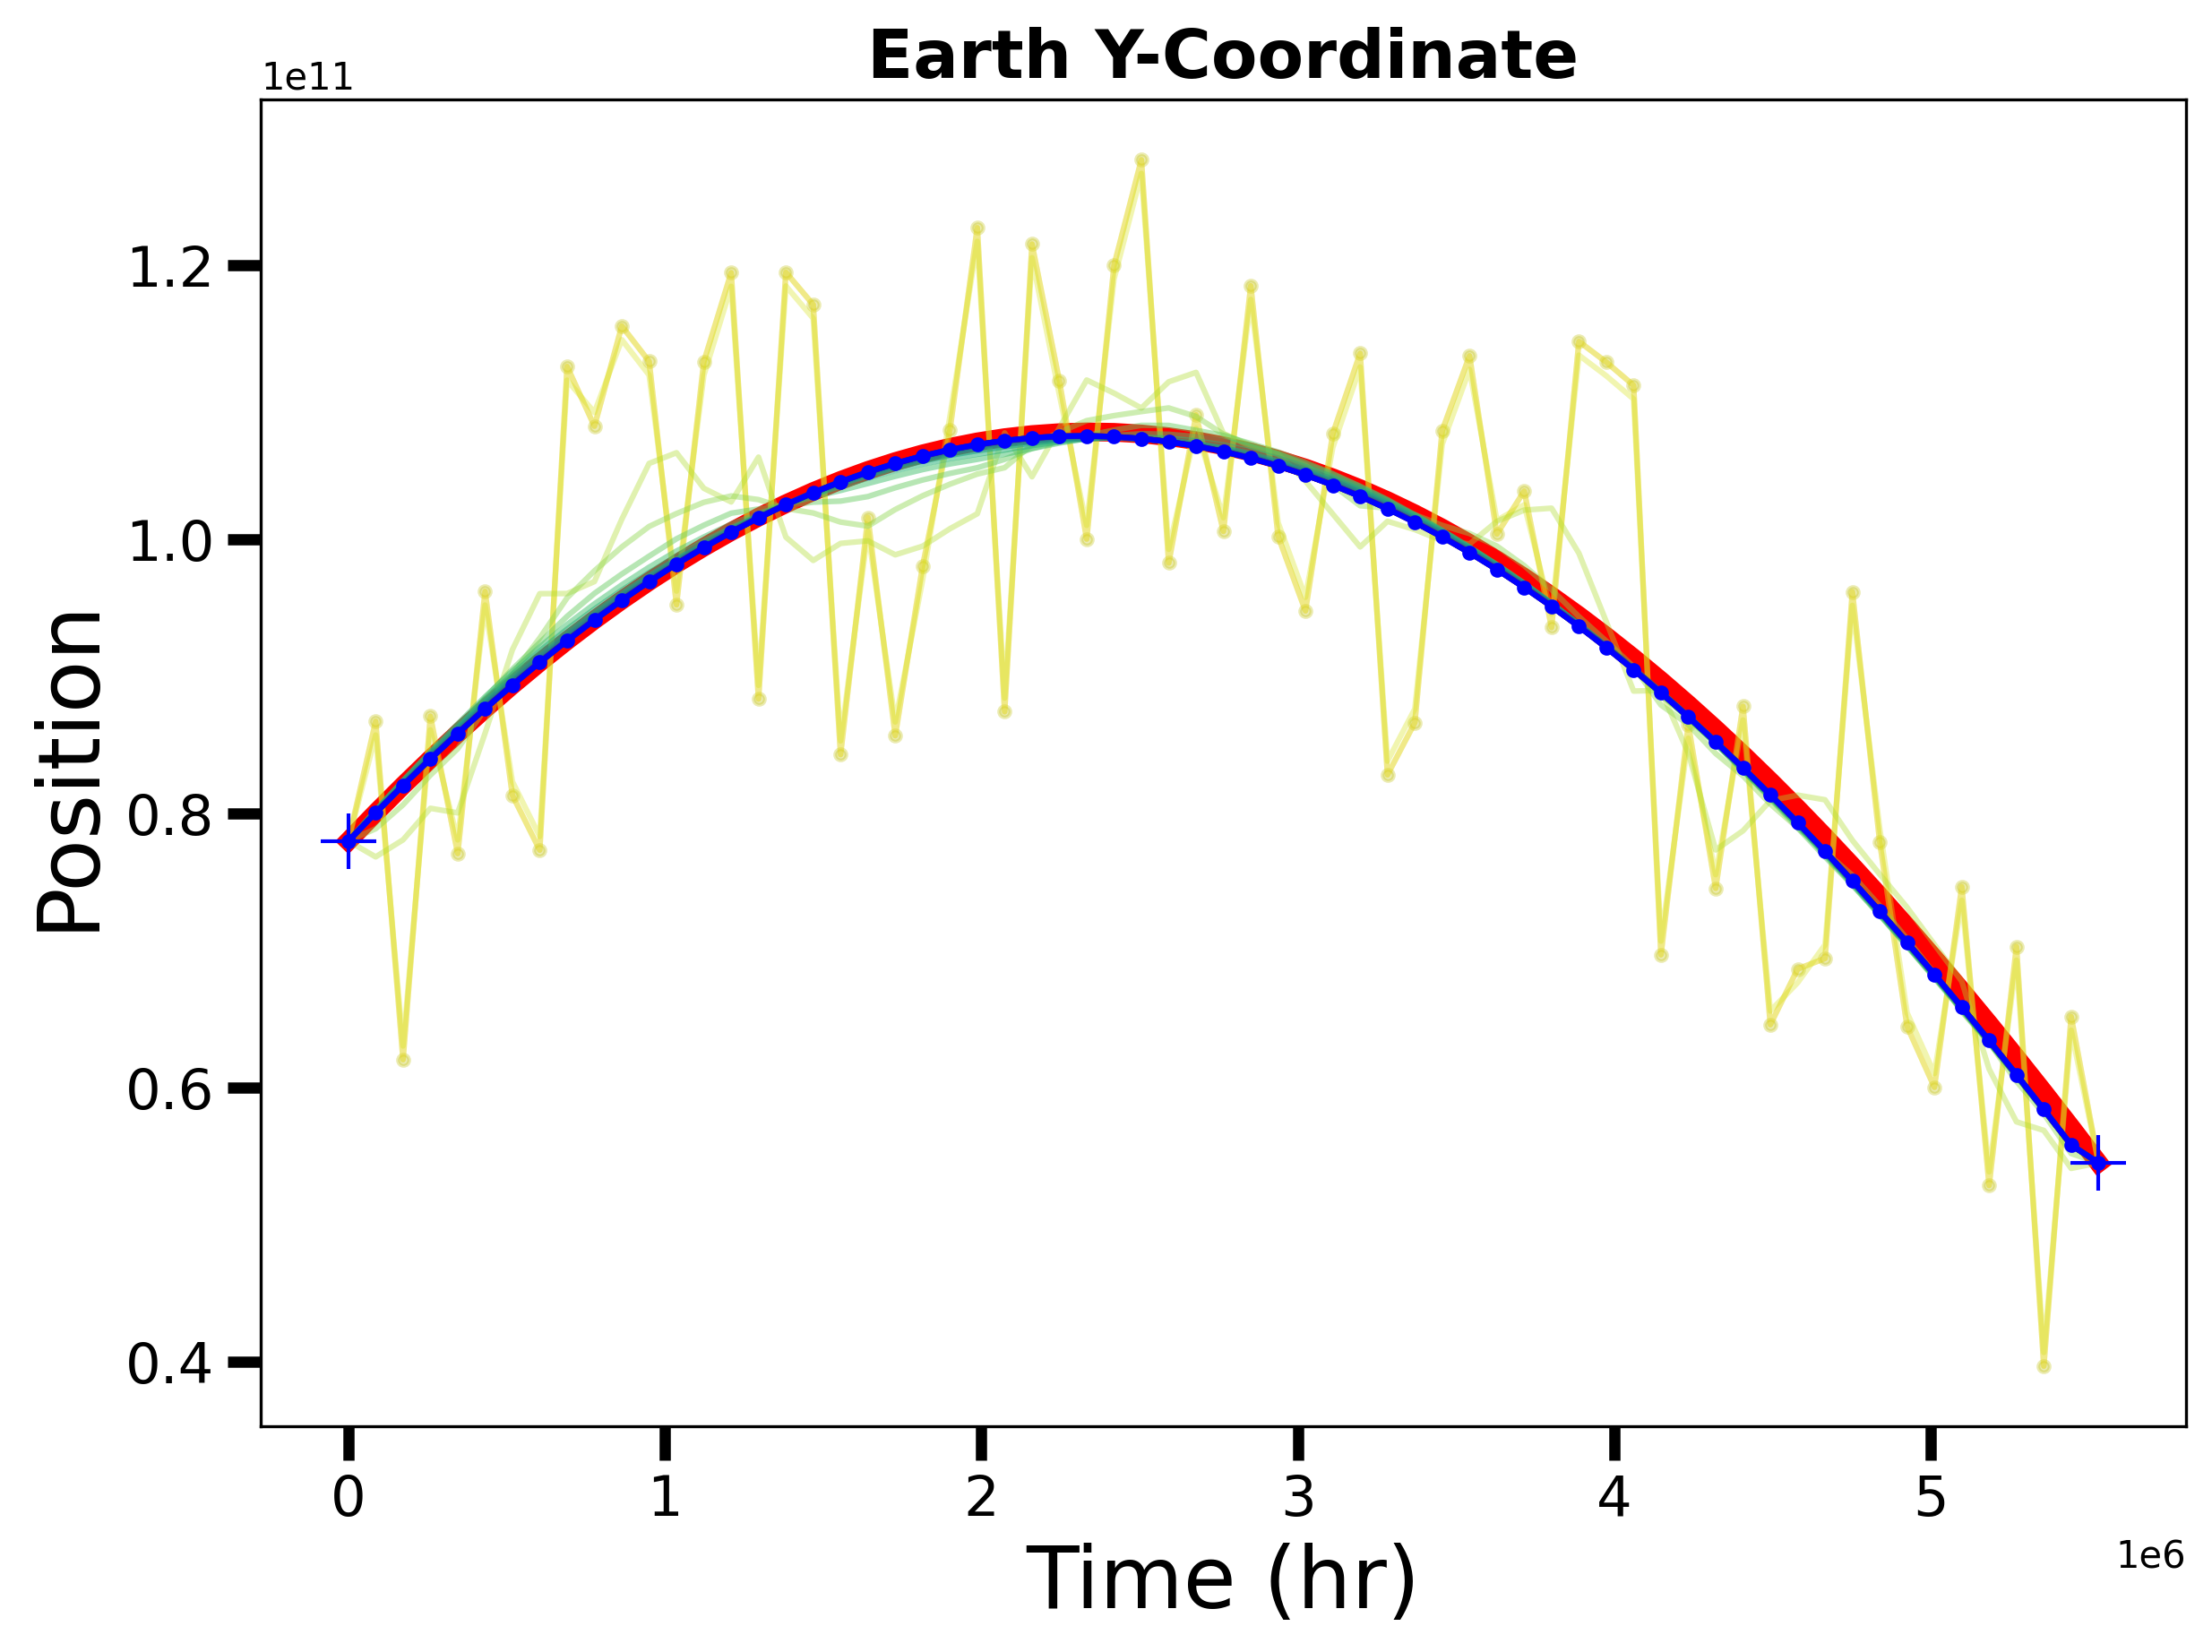

In [79]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=300)
ax = fig.add_subplot(111)

ax.plot(t_min, x_sim.reshape(-1,N,2)[:, 2, 1], 'r-', label='ODE solution', linewidth=5)
ax.plot(t_min, xs_min[0].reshape(-1,N,2)[:, 2, 1], 'y.-', alpha=.3, label='Initial (random) path')
for i, xi in enumerate(xs_min):
    label = 'During optimization' if i==10 else None
    ax.plot(t_min, xs_min[i].detach().numpy().reshape(-1,N,2)[:, 2, 1], alpha=.3 + .7 * i/(17), color=plt.cm.viridis( 1-i/(17) ), label=label)
ax.plot(t_min, xs_min[-1].detach().numpy().reshape(-1,N,2)[:, 2, 1], 'b.-', label='Final (optimized) path')
ax.plot(t_min[[0,-1]], xs_min[0].detach().numpy().reshape(-1,N,2)[:, 2, 1][[0,-1]], 'b+', markersize=15, label='Points held constant')


ax_labels = {'title':'Earth Y-Coordinate',
             'x_label':'Time (hr)', 'y_label':'Position (m)'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 23, 'legend': 10}

plot_helper(ax, ax_labels, fontsz)
path ='./dynamic/{}.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

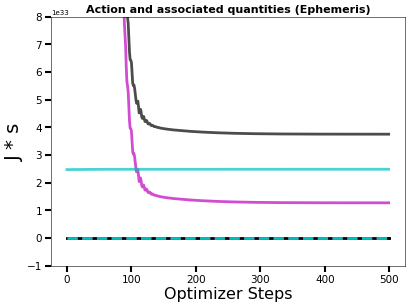

In [90]:
name = 'Ephemeris'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
fig = action_plot(info, x_sim, ax_labels, fontsz, L_fn=lagrangian_3body)
plt.ylim(-1e33, .8e34)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', ''))
plt.show() ; fig.savefig(path)

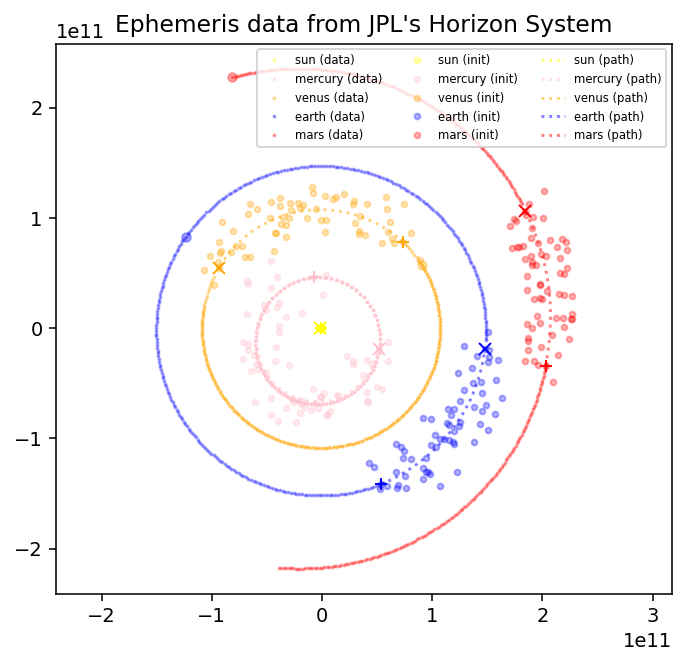

In [80]:
fig = plt.figure(figsize=[5,5], dpi=140)
plot_planets(df, planets, fig=fig)
colors = get_planet_colors()

xs = xs_min[0].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, '.', alpha=0.3, color=colors[planet], label=planets[i] + ' (init)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
    
xs = xs_min[-1].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (path)')

plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=3) ; plt.show()